#### Distance Metrics to be Tested

1. Cosine 

In [22]:
#'''Required Libraries (uncomment for installation)'''

# !pip install pandas
# !pip install numpy
# !pip install scipy

In [37]:
'''Importing Libraries'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

#### Distance Calulations

In [24]:
def plot_graph(sim_arr, model, label, k, gr_type = '-k'):
    x = np.linspace(0, len(sim_arr)-1, len(sim_arr), dtype=int)
    plt.plot(x, sim_arr, gr_type)

    plt.title("Distance Similarity Scores at k = " + k)              
    plt.xlabel('Count')
    plt.ylabel('Simialrity Scores')

In [25]:
def performance_graph(cosi_2D, arr):

    for i in range(len(cosi_2D)):
        barWidth = 0.25
        fig = plt.subplots(figsize =(6, 4))

        # set height of bar
        cosi = cosi_2D[i]

        # Set position of bar on X axis
        br1 = np.arange(len(cosi))

        # Make the plot
        plt.bar(br1, cosi, color ='r', width = barWidth,
                edgecolor ='grey', label ='Cosine')

        # Adding Xticks
        plt.xlabel('K Value', fontsize = 12)
        plt.ylabel('Human-Model Weightage alignment', fontsize = 12)

        plt.legend()
        plt.show()

In [26]:
def human_sim_scoring(cont_arr, opt_list):
    opt_list_desc,count_arr = [], []
    
    # Arranging the distance array in descending order and deriving index values
    cont_arr = np.asarray(cont_arr)
    sort_idx = (-cont_arr).argsort()
    
    
    # Appending the options list as per the score array
    for i in range(len(sort_idx)):
        opt_list_new = []
        for j in range(len(sort_idx[0])):
            opt_list_new.append(opt_list[i][sort_idx[i][j]])
        opt_list_desc.append(opt_list_new)
    
    opt_list_desc = np.asarray(opt_list_desc)
    
    
    # Keeping the count with human similarity scores
    for i in range(len(opt_list)):
        count = 0
        for j in range(len(opt_list[i])):
            if (opt_list_desc[i][j] == opt_list[i][j]):
                count += 1
        count_arr.append(count)
     
    
    return count_arr

In [27]:
'''Calculations to cehck the closest analogy answer'''

def after_distance(cont_arr, optio):
    max_arr, idx2, word = [], [], []
    
    for instances in range(len(cont_arr)):
        max_arr.append(np.amax(cont_arr[instances]))
    
    for ind_val2 in range(len(max_arr)):
        idx2.append(np.where(cont_arr[ind_val2] == max_arr[ind_val2]))
    
    idx2 = np.asarray(idx2)

    for i in range(len(optio)):
        word.append(optio[i][idx2[i]])
    
    return max_arr, word

In [43]:
'''Calculating Distance Function'''

def cal_distances(quest, optio, k, model="LSA"):  
    cosi_score_avg = []
    cosi_arr = []
    cosi_arr_desc = []

    for i in range(len(quest)):
        tmp_arr_cosi = []
        tmp_arr_cosi_desc = []
        
        for j in range(len(optio[i])):
            
            if model == "LSA":
                # Calculating Cosine 
                tmp_arr_cosi.append(1 - (distance.cosine(dict_word_vectors[quest[i][0]] - dict_word_vectors[quest[i][2]], \
                                                         dict_word_vectors[quest[i][1]] - dict_word_vectors[optio[i][j]])))

                
            elif model == "GloVe":
                # Calculating Cosine 
                tmp_arr_cosi.append(1 - (distance.cosine(glove_word_vector[quest[i][0]] - glove_word_vector[quest[i][2]], \
                                                         glove_word_vector[quest[i][1]] - glove_word_vector[optio[i][j]])))
      
        
        # Appending Arrays
        cosi_arr.append(tmp_arr_cosi)
    
    # Calling function to get the highest similarity array and the highest similarty word
    max_arr_cosi, word_cosi = after_distance(cosi_arr, optio)
    
    # Human Answer Ranking Score calculations
    hum_sim_cosi = human_sim_scoring(cosi_arr, optio) 
    cosi_score_avg.append(np.average(hum_sim_cosi))
    
    
    '''Genrating Dataframes'''
  
    # For Human Prompt and Smilarity Scores wrt all prompts
    df_question  = pd.DataFrame(quest, columns=["Quest 1", "Quest 2", "Quest 3"])
    df_human_ans  = pd.DataFrame(ans_list, columns=["Prompt 1", "Prompt 2", "Prompt 3", "Prompt 4", "Prompt 5",])
    

    cosi_sim_scores = pd.DataFrame(cosi_arr, columns=["Similarity 1", "Similarity 2", "Similarity 3", "Similarity 4", "Similarity 5",])
    
        
    # For Calculated output derived from highest similarity
    tmp_cosi_df = pd.DataFrame({"Calculated":word_cosi, "Model Similarity": max_arr_cosi, "Score": hum_sim_cosi})
    
    
    # Merging known Datasets
    cosi_scores = df_question.join(cosi_sim_scores)
    
    cosi_merge_df = cosi_scores.join(df_human_ans)  
    
    
    # Merging different distance metrics into single Dataframe
    cosi_df = tmp_cosi_df.join(cosi_merge_df)

    
    # Generating Plots
    for i in k:
        plot_graph(max_arr_cosi, model, label = 'Cosine Distance', k = k, gr_type = '-r')
        plt.show()

    
    return cosi_df, cosi_score_avg

#### Calling Questions and Options Dataframes for list Conversions 

In [44]:
'''Create List for Questions, Options, and Answers (Human Prompts)'''

def conv_list(df):
    que_list, opt_list, ans_list = [], [], []
    
    for idx, row in df.iterrows():
        tmp_list_que = [row.prompt1, row.prompt2, row.prompt3]
        tmp_list_opt = [row.response1, row.response2, row.response3, row.response4, row.response5]
        tmp_list_ans = [row.response1, row.response2, row.response3, row.response4, row.response5]

        que_list.append(tmp_list_que)
        opt_list.append(tmp_list_opt)
        ans_list.append(tmp_list_ans)

    return np.asarray(que_list), np.asarray(opt_list), np.asarray(ans_list)

In [45]:
question = pd.read_csv('Que_Opt2.csv', index_col=0)
que_list, opt_list, ans_list = conv_list(question)

### Importing Models

#### LSA .txt files for different k values

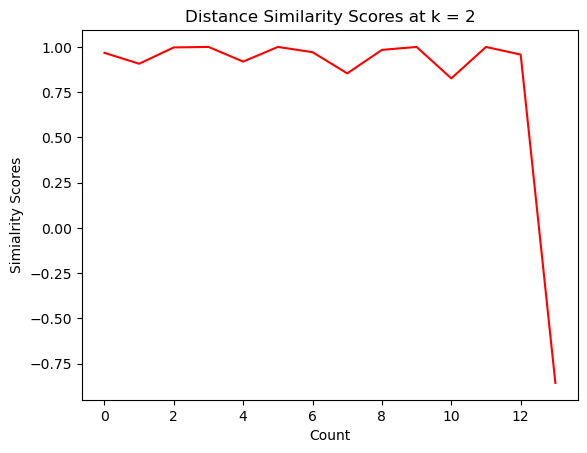

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.967294,2,movie,screen,lightning,0.967294,0.959494,-0.424758,-0.915062,0.739097,sky,storm,bolt,camera,thunder
1,[['food']],0.907033,3,furnace,coal,stomach,0.907033,-0.477527,0.769567,-0.581071,-0.589021,food,acid,heat,ulcers,digestive
2,[['moat']],0.997228,0,bracelet,wrist,moat,-0.941188,-0.806765,-0.906891,0.997228,-0.765264,water,castle,arm,moat,fort
3,[['grape']],1.000000,1,law,school,lawyer,0.999909,1.000000,0.999733,0.999999,0.995573,vineyard,grape,grapes,gardener,wine
4,[['boil']],0.918945,0,multiplication,product,brewing,0.804691,-0.051984,0.918945,0.883898,0.583044,tea,beer,boil,coffee,drink
5,[['growing']],0.999972,0,revising,manuscript,evolving,0.999948,-0.994258,0.999972,-0.997006,0.961307,life,species,growing,organism,change
6,[['lab']],0.970978,0,baker,cake,scientist,0.246221,-0.274654,-0.297922,0.951873,0.970978,experiment,science,theory,formula,lab
7,[['goal']],0.853819,2,sugar,coffee,incentive,-0.926326,0.853819,-0.819954,-0.848369,0.237808,tea,goal,money,work,task
8,[['poor']],0.983639,1,blindness,sight,poverty,-0.996952,-0.324597,-0.999459,0.983639,-0.993596,wealth,money,rich,poor,brightness
9,[['container']],0.999970,1,pen,pig,reservoir,-0.990426,-0.999827,-0.957173,0.999970,-0.945869,water,dog,lake,container,fish


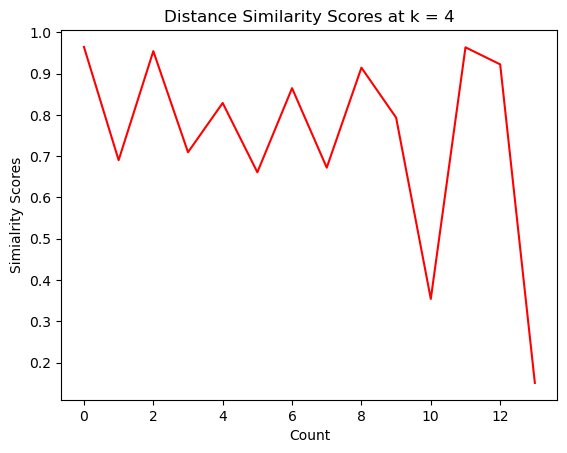

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.964493,2,movie,screen,lightning,0.964493,0.950929,0.550349,0.101855,0.860553,sky,storm,bolt,camera,thunder
1,[['food']],0.690251,2,furnace,coal,stomach,0.690251,-0.474982,0.542749,-0.432113,-0.404222,food,acid,heat,ulcers,digestive
2,[['moat']],0.954310,1,bracelet,wrist,moat,-0.390254,0.171607,-0.218719,0.954310,-0.172592,water,castle,arm,moat,fort
3,[['grape']],0.709425,1,law,school,lawyer,0.687028,0.709425,0.635572,0.682586,0.507345,vineyard,grape,grapes,gardener,wine
4,[['coffee']],0.828793,0,multiplication,product,brewing,0.302444,-0.193928,-0.304483,0.828793,0.277910,tea,beer,boil,coffee,drink
5,[['change']],0.660929,1,revising,manuscript,evolving,0.571411,-0.727580,0.518038,-0.826533,0.660929,life,species,growing,organism,change
6,[['formula']],0.864650,0,baker,cake,scientist,0.376532,0.019307,-0.050094,0.864650,0.185168,experiment,science,theory,formula,lab
7,[['goal']],0.672158,1,sugar,coffee,incentive,-0.026812,0.672158,-0.773168,-0.590107,0.426530,tea,goal,money,work,task
8,[['poor']],0.914265,1,blindness,sight,poverty,-0.896857,-0.610025,-0.941871,0.914265,-0.874083,wealth,money,rich,poor,brightness
9,[['container']],0.793246,0,pen,pig,reservoir,-0.875031,-0.700722,-0.430085,0.793246,-0.690346,water,dog,lake,container,fish


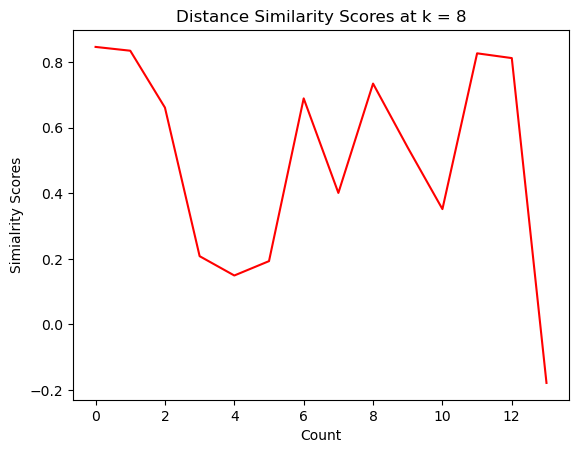

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.845792,2,movie,screen,lightning,0.845792,0.829940,0.320888,-0.219489,0.767970,sky,storm,bolt,camera,thunder
1,[['food']],0.834229,1,furnace,coal,stomach,0.834229,-0.468849,0.738785,-0.479848,-0.395433,food,acid,heat,ulcers,digestive
2,[['fort']],0.660818,0,bracelet,wrist,moat,0.257680,-0.207051,0.045282,0.350058,0.660818,water,castle,arm,moat,fort
3,[['gardener']],0.208013,1,law,school,lawyer,0.024120,0.007846,0.003324,0.208013,-0.019314,vineyard,grape,grapes,gardener,wine
4,[['coffee']],0.149117,0,multiplication,product,brewing,-0.502523,-0.203825,-0.276442,0.149117,0.104143,tea,beer,boil,coffee,drink
5,[['life']],0.192895,3,revising,manuscript,evolving,0.192895,0.144829,0.039598,-0.274520,-0.038110,life,species,growing,organism,change
6,[['lab']],0.688916,2,baker,cake,scientist,0.403436,0.652820,0.412300,0.235073,0.688916,experiment,science,theory,formula,lab
7,[['money']],0.400809,0,sugar,coffee,incentive,0.188248,0.053476,0.400809,-0.445626,0.313269,tea,goal,money,work,task
8,[['poor']],0.734040,2,blindness,sight,poverty,0.383378,0.342064,0.375149,0.734040,0.092073,wealth,money,rich,poor,brightness
9,[['container']],0.539115,1,pen,pig,reservoir,-0.432413,-0.648521,-0.277402,0.539115,-0.210388,water,dog,lake,container,fish


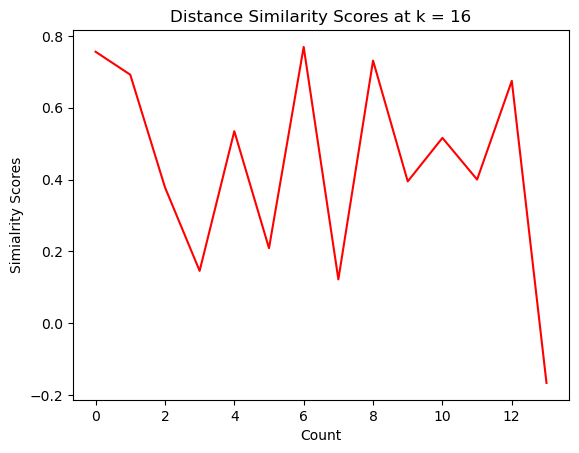

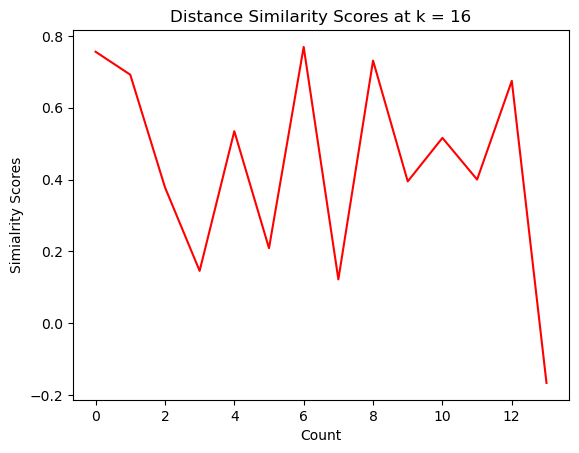

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.755812,2,movie,screen,lightning,0.755812,0.476789,0.062327,-0.192856,0.409807,sky,storm,bolt,camera,thunder
1,[['food']],0.691893,1,furnace,coal,stomach,0.691893,0.029469,0.400145,-0.427952,-0.405359,food,acid,heat,ulcers,digestive
2,[['moat']],0.378645,0,bracelet,wrist,moat,-0.421252,0.235108,0.241221,0.378645,-0.130017,water,castle,arm,moat,fort
3,[['gardener']],0.145812,2,law,school,lawyer,0.091847,0.094219,0.079401,0.145812,-0.072634,vineyard,grape,grapes,gardener,wine
4,[['coffee']],0.534635,0,multiplication,product,brewing,-0.523521,0.210944,-0.374729,0.534635,0.245919,tea,beer,boil,coffee,drink
5,[['life']],0.209047,1,revising,manuscript,evolving,0.209047,-0.265995,-0.081244,-0.432095,-0.123250,life,species,growing,organism,change
6,[['lab']],0.769183,2,baker,cake,scientist,0.530452,0.762545,0.699086,0.444787,0.769183,experiment,science,theory,formula,lab
7,[['task']],0.122136,0,sugar,coffee,incentive,-0.022606,-0.202316,0.070049,-0.575680,0.122136,tea,goal,money,work,task
8,[['poor']],0.731081,1,blindness,sight,poverty,0.416897,0.410160,0.466552,0.731081,0.130549,wealth,money,rich,poor,brightness
9,[['container']],0.394806,0,pen,pig,reservoir,-0.014584,-0.467713,-0.251043,0.394806,-0.250764,water,dog,lake,container,fish


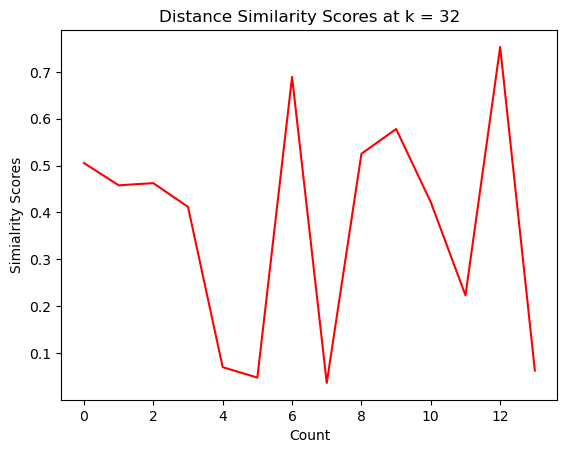

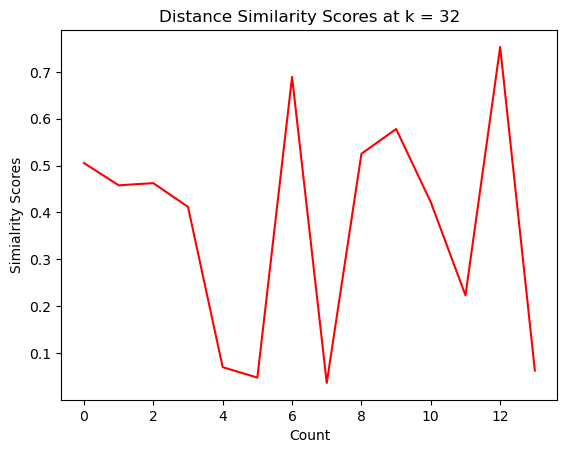

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.505518,1,movie,screen,lightning,0.505518,0.234908,0.110034,-0.161520,0.277080,sky,storm,bolt,camera,thunder
1,[['food']],0.457982,5,furnace,coal,stomach,0.457982,0.080106,0.014482,-0.116280,-0.117868,food,acid,heat,ulcers,digestive
2,[['moat']],0.462578,2,bracelet,wrist,moat,-0.405025,0.449949,0.448935,0.462578,0.190380,water,castle,arm,moat,fort
3,[['gardener']],0.411948,1,law,school,lawyer,0.386604,0.386530,0.390097,0.411948,0.244233,vineyard,grape,grapes,gardener,wine
4,[['drink']],0.069969,0,multiplication,product,brewing,-0.156509,-0.175052,0.053017,-0.126849,0.069969,tea,beer,boil,coffee,drink
5,[['life']],0.047714,1,revising,manuscript,evolving,0.047714,-0.230424,-0.478618,-0.489261,-0.096151,life,species,growing,organism,change
6,[['science']],0.689157,0,baker,cake,scientist,0.440002,0.689157,0.436841,-0.079956,0.573209,experiment,science,theory,formula,lab
7,[['task']],0.036355,0,sugar,coffee,incentive,-0.262140,-0.156537,-0.141330,-0.338109,0.036355,tea,goal,money,work,task
8,[['money']],0.525225,3,blindness,sight,poverty,0.499718,0.525225,0.487372,0.449990,0.269445,wealth,money,rich,poor,brightness
9,[['container']],0.578040,0,pen,pig,reservoir,0.080255,-0.088635,0.097421,0.578040,0.082426,water,dog,lake,container,fish


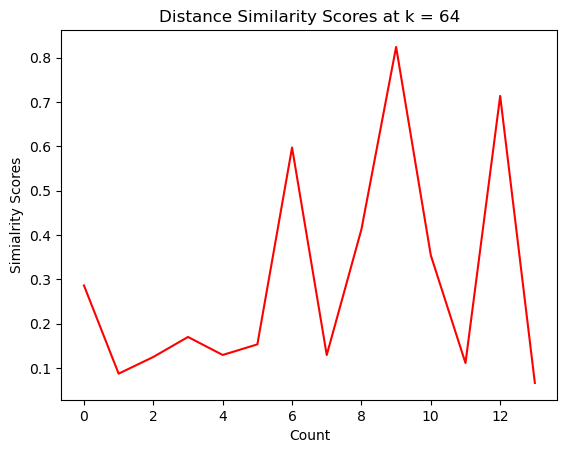

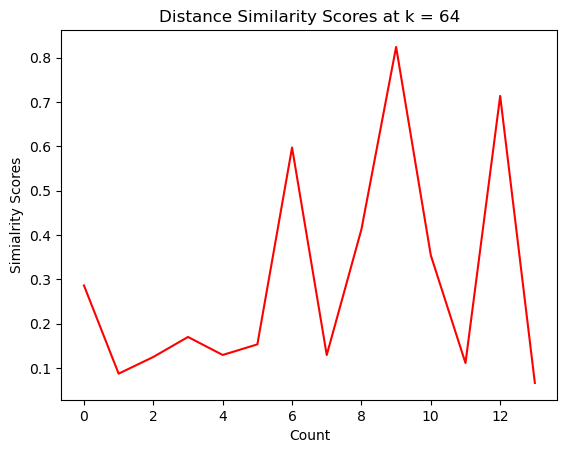

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.286298,1,movie,screen,lightning,0.286298,0.109662,-0.000643,-0.153049,0.143639,sky,storm,bolt,camera,thunder
1,[['food']],0.087304,3,furnace,coal,stomach,0.087304,-0.008857,-0.071355,-0.107382,-0.102928,food,acid,heat,ulcers,digestive
2,[['arm']],0.124983,0,bracelet,wrist,moat,-0.140211,0.010755,0.124983,0.064719,0.041889,water,castle,arm,moat,fort
3,[['gardener']],0.170109,1,law,school,lawyer,0.142589,0.143640,0.146350,0.170109,0.096974,vineyard,grape,grapes,gardener,wine
4,[['drink']],0.129484,1,multiplication,product,brewing,-0.106601,0.043121,0.054317,-0.049191,0.129484,tea,beer,boil,coffee,drink
5,[['life']],0.153381,1,revising,manuscript,evolving,0.153381,-0.082432,-0.144656,-0.264971,-0.016409,life,species,growing,organism,change
6,[['science']],0.597442,0,baker,cake,scientist,0.407809,0.597442,0.359839,0.067814,0.486044,experiment,science,theory,formula,lab
7,[['task']],0.129344,0,sugar,coffee,incentive,-0.107062,0.015283,-0.044161,0.118207,0.129344,tea,goal,money,work,task
8,[['money']],0.412872,3,blindness,sight,poverty,0.400237,0.412872,0.395014,0.326327,0.231366,wealth,money,rich,poor,brightness
9,[['container']],0.824392,0,pen,pig,reservoir,0.638407,0.647346,0.773295,0.824392,0.755693,water,dog,lake,container,fish


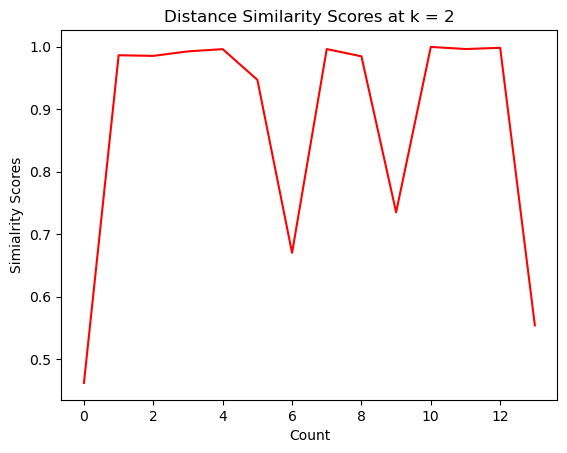

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.461910,2,movie,screen,lightning,0.461910,0.126821,-0.966439,-0.997553,-0.534020,sky,storm,bolt,camera,thunder
1,[['food']],0.986376,1,furnace,coal,stomach,0.986376,0.937433,0.979531,-0.983687,-0.804793,food,acid,heat,ulcers,digestive
2,[['fort']],0.985347,3,bracelet,wrist,moat,-0.411698,0.977184,0.851437,0.384861,0.985347,water,castle,arm,moat,fort
3,[['wine']],0.992576,3,law,school,lawyer,0.918264,0.987233,0.985996,0.925331,0.992576,vineyard,grape,grapes,gardener,wine
4,[['boil']],0.996125,0,multiplication,product,brewing,0.953252,-0.965071,0.996125,0.979072,-0.501496,tea,beer,boil,coffee,drink
5,[['organism']],0.947028,2,revising,manuscript,evolving,0.019421,0.848438,0.782724,0.947028,0.379853,life,species,growing,organism,change
6,[['lab']],0.670100,0,baker,cake,scientist,0.536395,0.282724,0.384690,0.636083,0.670100,experiment,science,theory,formula,lab
7,[['goal']],0.996219,2,sugar,coffee,incentive,-0.878148,0.996219,0.817974,0.276028,0.994131,tea,goal,money,work,task
8,[['poor']],0.984634,2,blindness,sight,poverty,0.239906,0.961937,-0.804818,0.984634,-0.858092,wealth,money,rich,poor,brightness
9,[['container']],0.735027,0,pen,pig,reservoir,0.258891,-0.920076,-0.759337,0.735027,0.299714,water,dog,lake,container,fish


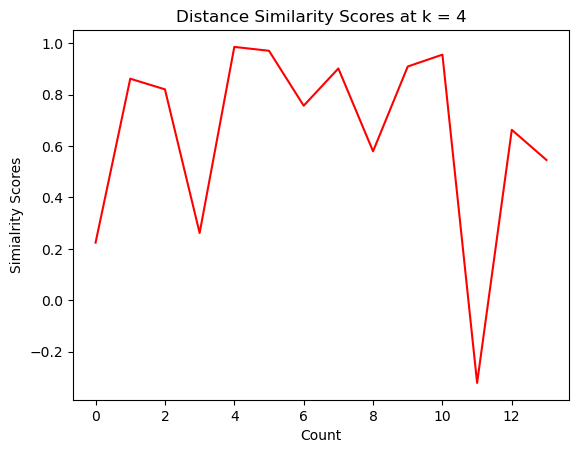

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['storm']],0.224098,0,movie,screen,lightning,-0.267527,0.224098,-0.242553,-0.979310,-0.403982,sky,storm,bolt,camera,thunder
1,[['acid']],0.861778,0,furnace,coal,stomach,0.635680,0.861778,0.741348,-0.671756,0.005582,food,acid,heat,ulcers,digestive
2,[['arm']],0.820395,2,bracelet,wrist,moat,-0.271591,0.781053,0.820395,0.550322,0.654316,water,castle,arm,moat,fort
3,[['wine']],0.261654,3,law,school,lawyer,0.144994,0.209179,0.203650,0.175271,0.261654,vineyard,grape,grapes,gardener,wine
4,[['coffee']],0.985417,2,multiplication,product,brewing,0.912259,0.731867,0.760057,0.985417,0.657363,tea,beer,boil,coffee,drink
5,[['organism']],0.970448,1,revising,manuscript,evolving,0.645469,0.947773,0.537088,0.970448,0.745532,life,species,growing,organism,change
6,[['science']],0.756817,2,baker,cake,scientist,0.539559,0.756817,0.732786,0.285132,0.224914,experiment,science,theory,formula,lab
7,[['goal']],0.901635,2,sugar,coffee,incentive,-0.320390,0.901635,0.773137,0.320173,0.881611,tea,goal,money,work,task
8,[['poor']],0.579413,2,blindness,sight,poverty,0.296029,0.342448,-0.153739,0.579413,-0.336118,wealth,money,rich,poor,brightness
9,[['container']],0.909182,0,pen,pig,reservoir,0.085513,-0.913380,-0.278216,0.909182,0.223407,water,dog,lake,container,fish


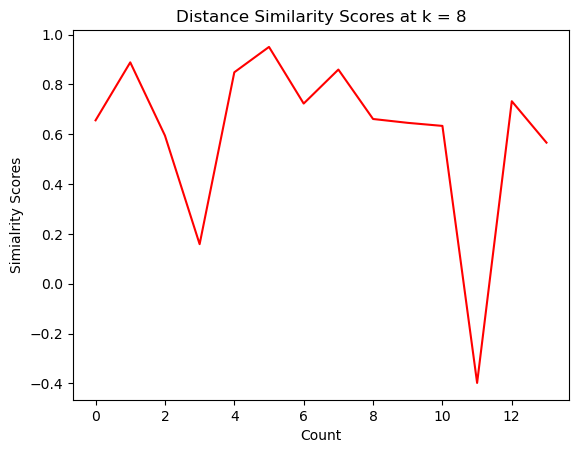

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['storm']],0.656031,1,movie,screen,lightning,0.639962,0.656031,-0.787419,-0.631453,0.162267,sky,storm,bolt,camera,thunder
1,[['acid']],0.888769,0,furnace,coal,stomach,0.569504,0.888769,0.603448,-0.424407,0.152937,food,acid,heat,ulcers,digestive
2,[['fort']],0.594860,1,bracelet,wrist,moat,0.166786,0.558272,0.135286,0.475472,0.594860,water,castle,arm,moat,fort
3,[['wine']],0.158860,0,law,school,lawyer,0.116886,0.126603,0.131212,0.131008,0.158860,vineyard,grape,grapes,gardener,wine
4,[['coffee']],0.848860,1,multiplication,product,brewing,0.790407,0.679380,0.542254,0.848860,0.541861,tea,beer,boil,coffee,drink
5,[['species']],0.950703,1,revising,manuscript,evolving,0.386725,0.950703,0.660690,0.896014,0.595135,life,species,growing,organism,change
6,[['science']],0.723335,2,baker,cake,scientist,0.313799,0.723335,0.623628,0.168558,0.120396,experiment,science,theory,formula,lab
7,[['goal']],0.859810,2,sugar,coffee,incentive,-0.030830,0.859810,0.597009,0.400004,0.819694,tea,goal,money,work,task
8,[['poor']],0.661353,2,blindness,sight,poverty,0.498950,0.298242,0.344042,0.661353,-0.054446,wealth,money,rich,poor,brightness
9,[['container']],0.645909,0,pen,pig,reservoir,0.098439,-0.177408,0.080716,0.645909,0.142050,water,dog,lake,container,fish


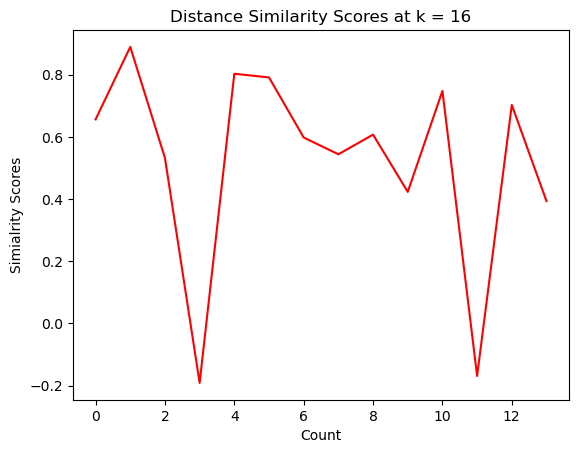

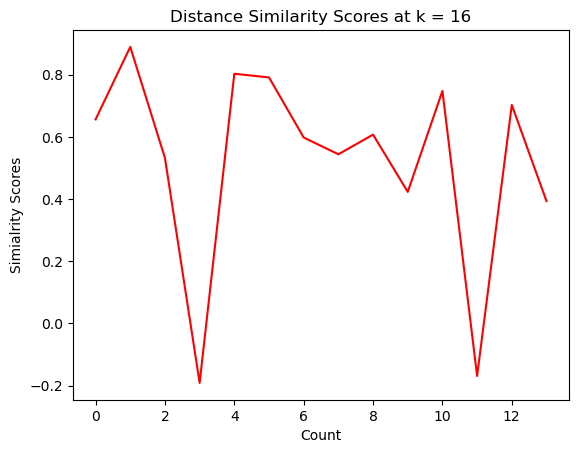

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['storm']],0.656375,0,movie,screen,lightning,0.578526,0.656375,0.014377,-0.147311,0.487956,sky,storm,bolt,camera,thunder
1,[['digestive']],0.889570,1,furnace,coal,stomach,0.747217,0.633290,0.148092,0.500069,0.889570,food,acid,heat,ulcers,digestive
2,[['castle']],0.532339,0,bracelet,wrist,moat,0.099796,0.532339,0.005606,-0.055871,0.070678,water,castle,arm,moat,fort
3,[['wine']],-0.191170,1,law,school,lawyer,-0.209507,-0.193202,-0.201534,-0.201474,-0.191170,vineyard,grape,grapes,gardener,wine
4,[['tea']],0.803253,1,multiplication,product,brewing,0.803253,0.470364,-0.048691,0.487188,0.536117,tea,beer,boil,coffee,drink
5,[['organism']],0.791420,1,revising,manuscript,evolving,0.432413,0.701313,0.233599,0.791420,0.463154,life,species,growing,organism,change
6,[['science']],0.598190,2,baker,cake,scientist,0.156302,0.598190,0.560498,0.080077,0.057094,experiment,science,theory,formula,lab
7,[['goal']],0.544251,2,sugar,coffee,incentive,0.196582,0.544251,0.490108,0.234414,0.515665,tea,goal,money,work,task
8,[['rich']],0.607457,1,blindness,sight,poverty,0.593111,0.130274,0.607457,0.496497,0.102260,wealth,money,rich,poor,brightness
9,[['container']],0.423337,1,pen,pig,reservoir,0.118638,-0.393271,-0.000284,0.423337,-0.049383,water,dog,lake,container,fish


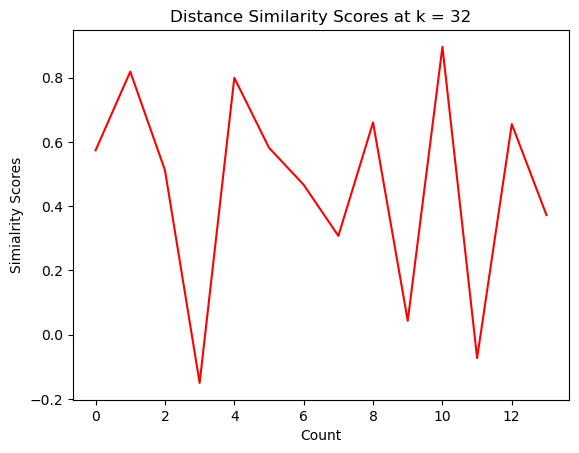

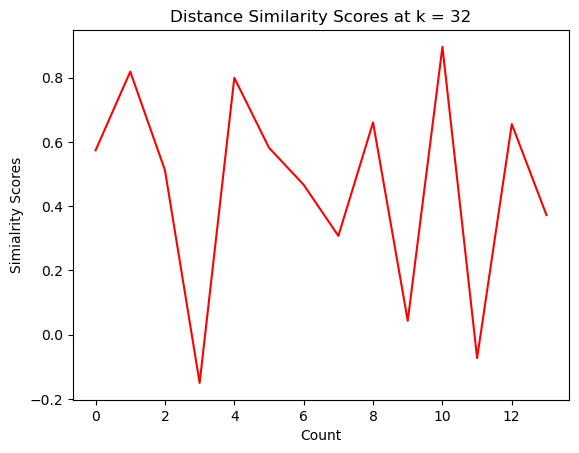

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['storm']],0.574077,0,movie,screen,lightning,0.443404,0.574077,0.282500,-0.171995,0.452976,sky,storm,bolt,camera,thunder
1,[['digestive']],0.819038,1,furnace,coal,stomach,0.454707,0.569043,0.218462,0.542487,0.819038,food,acid,heat,ulcers,digestive
2,[['castle']],0.512201,1,bracelet,wrist,moat,0.039676,0.512201,0.255086,0.144926,-0.007344,water,castle,arm,moat,fort
3,[['grapes']],-0.150559,2,law,school,lawyer,-0.174620,-0.151932,-0.150559,-0.171076,-0.196620,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.799862,0,multiplication,product,brewing,0.473897,0.799862,0.382455,-0.102025,0.755458,tea,beer,boil,coffee,drink
5,[['species']],0.582053,0,revising,manuscript,evolving,0.195708,0.582053,0.092721,0.548420,0.212357,life,species,growing,organism,change
6,[['theory']],0.466611,3,baker,cake,scientist,0.113108,0.370276,0.466611,0.060057,0.004102,experiment,science,theory,formula,lab
7,[['goal']],0.307525,1,sugar,coffee,incentive,0.151541,0.307525,0.226801,0.106536,0.303246,tea,goal,money,work,task
8,[['wealth']],0.660843,3,blindness,sight,poverty,0.660843,0.410230,0.591737,0.375784,0.306208,wealth,money,rich,poor,brightness
9,[['water']],0.043077,1,pen,pig,reservoir,0.043077,-0.483869,-0.027444,-0.159900,-0.182203,water,dog,lake,container,fish


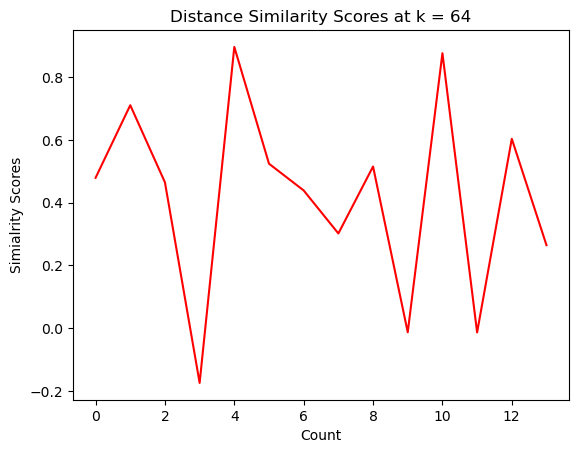

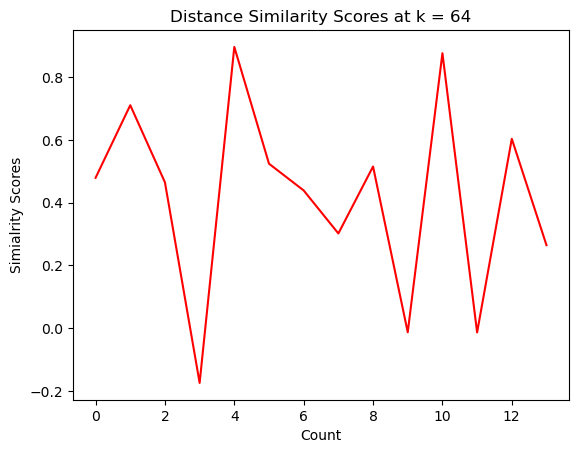

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.479037,2,movie,screen,lightning,0.479037,0.401050,0.312894,-0.148436,0.395006,sky,storm,bolt,camera,thunder
1,[['digestive']],0.710625,0,furnace,coal,stomach,0.428763,0.458085,0.193146,0.468325,0.710625,food,acid,heat,ulcers,digestive
2,[['moat']],0.464587,2,bracelet,wrist,moat,-0.003119,0.313305,0.236736,0.464587,0.045016,water,castle,arm,moat,fort
3,[['grapes']],-0.174850,2,law,school,lawyer,-0.190016,-0.174965,-0.174850,-0.189940,-0.207357,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.896419,1,multiplication,product,brewing,0.061271,0.896419,0.308912,-0.202228,0.763121,tea,beer,boil,coffee,drink
5,[['organism']],0.524112,1,revising,manuscript,evolving,0.224033,0.341552,0.135149,0.524112,0.309616,life,species,growing,organism,change
6,[['theory']],0.438777,1,baker,cake,scientist,0.004807,0.188078,0.438777,0.094125,0.024557,experiment,science,theory,formula,lab
7,[['task']],0.301644,3,sugar,coffee,incentive,-0.089915,0.291381,0.220551,0.080792,0.301644,tea,goal,money,work,task
8,[['wealth']],0.515110,2,blindness,sight,poverty,0.515110,0.243669,0.465024,0.287126,0.177471,wealth,money,rich,poor,brightness
9,[['water']],-0.013292,2,pen,pig,reservoir,-0.013292,-0.527189,-0.076711,-0.053907,-0.145412,water,dog,lake,container,fish


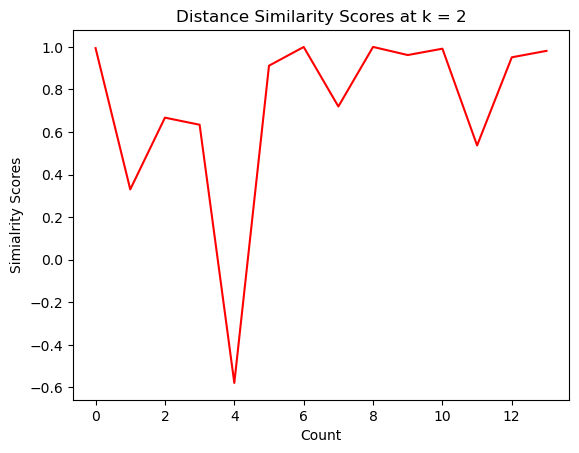

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['sky']],0.994200,1,movie,screen,lightning,0.994200,0.984423,-0.875958,-0.989832,0.987780,sky,storm,bolt,camera,thunder
1,[['food']],0.330336,1,furnace,coal,stomach,0.330336,-0.709504,-0.999692,-0.583540,-0.578460,food,acid,heat,ulcers,digestive
2,[['castle']],0.667479,2,bracelet,wrist,moat,0.290410,0.667479,0.462658,-0.993684,-0.999783,water,castle,arm,moat,fort
3,[['gardener']],0.634069,2,law,school,lawyer,0.632378,0.454209,0.510536,0.634069,-0.324641,vineyard,grape,grapes,gardener,wine
4,[['drink']],-0.578817,0,multiplication,product,brewing,-0.991484,-0.997779,-0.999612,-0.957592,-0.578817,tea,beer,boil,coffee,drink
5,[['growing']],0.911533,0,revising,manuscript,evolving,0.839232,0.662345,0.911533,0.537621,0.557785,life,species,growing,organism,change
6,[['lab']],0.999504,1,baker,cake,scientist,0.996031,0.908615,0.996959,0.997994,0.999504,experiment,science,theory,formula,lab
7,[['goal']],0.719869,0,sugar,coffee,incentive,-0.999278,0.719869,-0.999688,-0.825085,-0.532383,tea,goal,money,work,task
8,[['poor']],0.999728,1,blindness,sight,poverty,0.651153,0.744416,-0.587427,0.999728,-0.350658,wealth,money,rich,poor,brightness
9,[['container']],0.961555,1,pen,pig,reservoir,0.181343,-0.960973,0.602393,0.961555,0.629050,water,dog,lake,container,fish


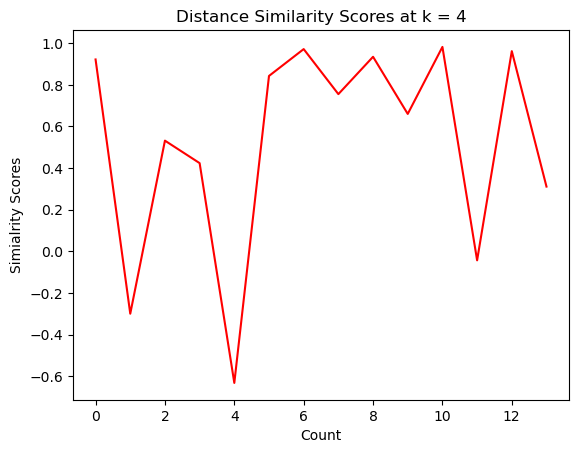

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['storm']],0.921753,1,movie,screen,lightning,0.307869,0.921753,-0.863472,-0.691853,0.769459,sky,storm,bolt,camera,thunder
1,[['food']],-0.299103,1,furnace,coal,stomach,-0.299103,-0.804499,-0.780762,-0.748262,-0.746033,food,acid,heat,ulcers,digestive
2,[['water']],0.531863,3,bracelet,wrist,moat,0.531863,0.299685,0.056755,-0.753674,-0.605926,water,castle,arm,moat,fort
3,[['grapes']],0.423900,2,law,school,lawyer,0.242175,0.372642,0.423900,0.300217,0.351462,vineyard,grape,grapes,gardener,wine
4,[['drink']],-0.631588,1,multiplication,product,brewing,-0.955177,-0.894151,-0.999118,-0.943586,-0.631588,tea,beer,boil,coffee,drink
5,[['life']],0.842603,3,revising,manuscript,evolving,0.842603,0.734416,0.531988,0.429018,0.508529,life,species,growing,organism,change
6,[['formula']],0.971529,1,baker,cake,scientist,0.948199,0.743654,0.878937,0.971529,0.842625,experiment,science,theory,formula,lab
7,[['goal']],0.755290,0,sugar,coffee,incentive,-0.974584,0.755290,-0.780819,-0.511791,0.268710,tea,goal,money,work,task
8,[['poor']],0.934612,2,blindness,sight,poverty,0.385527,0.790354,-0.142089,0.934612,-0.268545,wealth,money,rich,poor,brightness
9,[['container']],0.660188,1,pen,pig,reservoir,0.122716,-0.927853,0.463141,0.660188,0.508929,water,dog,lake,container,fish


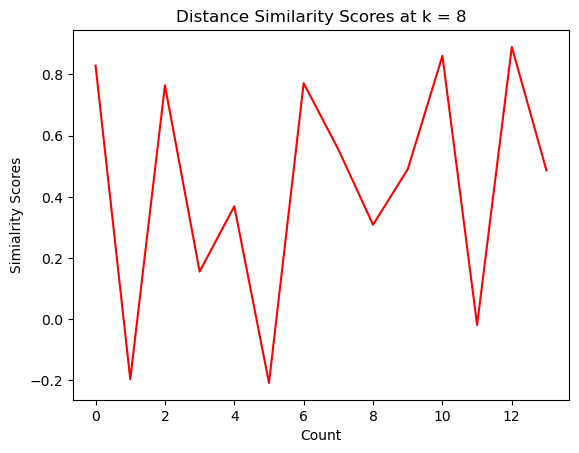

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.828602,0,movie,screen,lightning,0.588807,0.569433,-0.573891,-0.662365,0.828602,sky,storm,bolt,camera,thunder
1,[['heat']],-0.195737,0,furnace,coal,stomach,-0.491409,-0.298394,-0.195737,-0.246809,-0.216341,food,acid,heat,ulcers,digestive
2,[['water']],0.764422,3,bracelet,wrist,moat,0.764422,0.541503,0.014746,0.386015,-0.142933,water,castle,arm,moat,fort
3,[['grape']],0.155710,1,law,school,lawyer,-0.175283,0.155710,-0.001655,-0.073526,-0.281095,vineyard,grape,grapes,gardener,wine
4,[['drink']],0.369242,1,multiplication,product,brewing,-0.221603,0.185120,-0.296129,0.058991,0.369242,tea,beer,boil,coffee,drink
5,[['species']],-0.208015,0,revising,manuscript,evolving,-0.213218,-0.208015,-0.501848,-0.693039,-0.391175,life,species,growing,organism,change
6,[['formula']],0.771245,0,baker,cake,scientist,0.665570,0.665043,0.568034,0.771245,0.632033,experiment,science,theory,formula,lab
7,[['goal']],0.554753,0,sugar,coffee,incentive,-0.746709,0.554753,-0.374137,-0.044570,0.340064,tea,goal,money,work,task
8,[['poor']],0.308816,0,blindness,sight,poverty,-0.012542,-0.054898,-0.429761,0.308816,-0.234884,wealth,money,rich,poor,brightness
9,[['container']],0.490275,0,pen,pig,reservoir,0.419346,0.134741,0.476858,0.490275,0.379571,water,dog,lake,container,fish


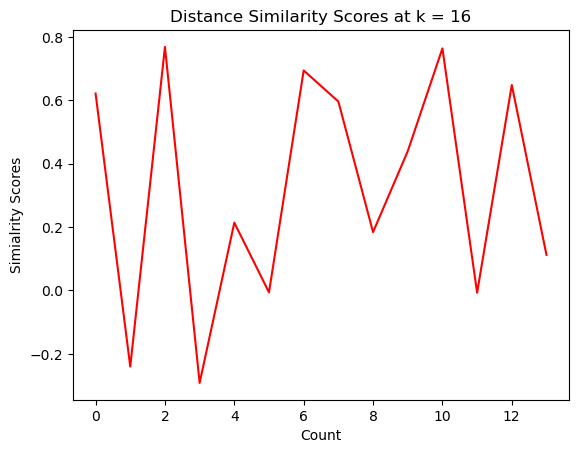

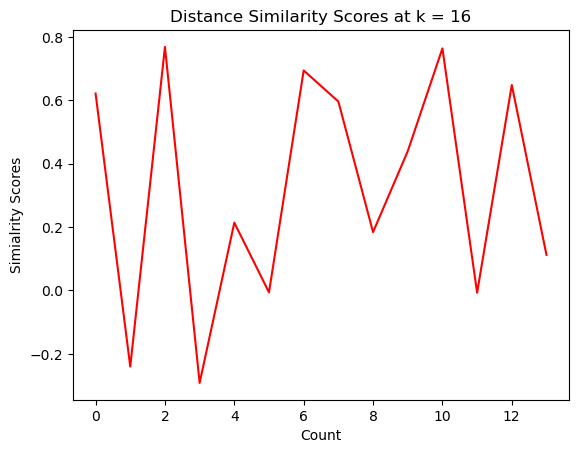

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.621546,2,movie,screen,lightning,-0.192292,0.513440,0.074036,-0.498421,0.621546,sky,storm,bolt,camera,thunder
1,[['heat']],-0.240275,0,furnace,coal,stomach,-0.261846,-0.474136,-0.240275,-0.535424,-0.522579,food,acid,heat,ulcers,digestive
2,[['moat']],0.768490,0,bracelet,wrist,moat,0.166821,0.222682,0.087068,0.768490,0.232525,water,castle,arm,moat,fort
3,[['grapes']],-0.291802,2,law,school,lawyer,-0.422375,-0.301118,-0.291802,-0.396516,-0.318507,vineyard,grape,grapes,gardener,wine
4,[['drink']],0.213929,1,multiplication,product,brewing,-0.356266,-0.090495,-0.484261,-0.306873,0.213929,tea,beer,boil,coffee,drink
5,[['species']],-0.005869,0,revising,manuscript,evolving,-0.248719,-0.005869,-0.270822,-0.210079,-0.091342,life,species,growing,organism,change
6,[['formula']],0.694240,0,baker,cake,scientist,0.688753,0.559075,0.624462,0.694240,0.626717,experiment,science,theory,formula,lab
7,[['goal']],0.596166,2,sugar,coffee,incentive,-0.570093,0.596166,-0.189352,-0.224500,0.449520,tea,goal,money,work,task
8,[['wealth']],0.184087,1,blindness,sight,poverty,0.184087,0.002410,-0.074365,0.029957,-0.044654,wealth,money,rich,poor,brightness
9,[['container']],0.439338,0,pen,pig,reservoir,0.259100,0.071762,0.340130,0.439338,0.333619,water,dog,lake,container,fish


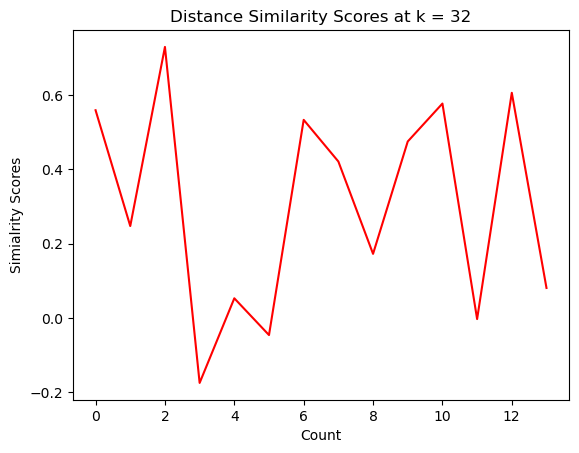

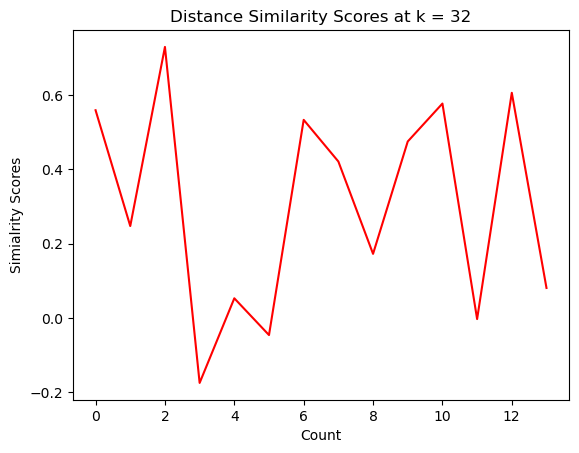

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['storm']],0.559306,1,movie,screen,lightning,-0.111247,0.559306,0.076779,-0.262640,0.559291,sky,storm,bolt,camera,thunder
1,[['heat']],0.247510,0,furnace,coal,stomach,-0.179906,-0.068398,0.247510,0.033451,-0.013395,food,acid,heat,ulcers,digestive
2,[['moat']],0.729735,2,bracelet,wrist,moat,-0.130014,0.274696,0.169416,0.729735,-0.119743,water,castle,arm,moat,fort
3,[['grapes']],-0.174852,1,law,school,lawyer,-0.196275,-0.187550,-0.174852,-0.175451,-0.445736,vineyard,grape,grapes,gardener,wine
4,[['coffee']],0.052996,1,multiplication,product,brewing,-0.032945,-0.021680,0.023883,0.052996,0.032355,tea,beer,boil,coffee,drink
5,[['species']],-0.045980,0,revising,manuscript,evolving,-0.207579,-0.045980,-0.429485,-0.216028,-0.224672,life,species,growing,organism,change
6,[['formula']],0.533383,1,baker,cake,scientist,0.292381,0.531912,0.442275,0.533383,0.484737,experiment,science,theory,formula,lab
7,[['goal']],0.421236,0,sugar,coffee,incentive,-0.370707,0.421236,-0.019322,-0.002633,0.367522,tea,goal,money,work,task
8,[['wealth']],0.172629,1,blindness,sight,poverty,0.172629,0.087294,-0.092204,0.163472,-0.025911,wealth,money,rich,poor,brightness
9,[['container']],0.475136,0,pen,pig,reservoir,0.365143,0.196571,0.458095,0.475136,0.355076,water,dog,lake,container,fish


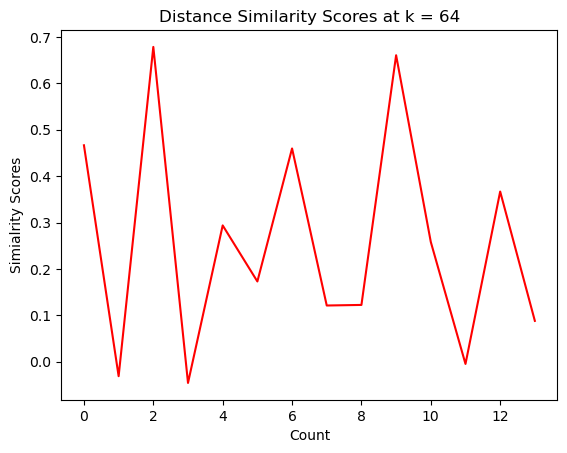

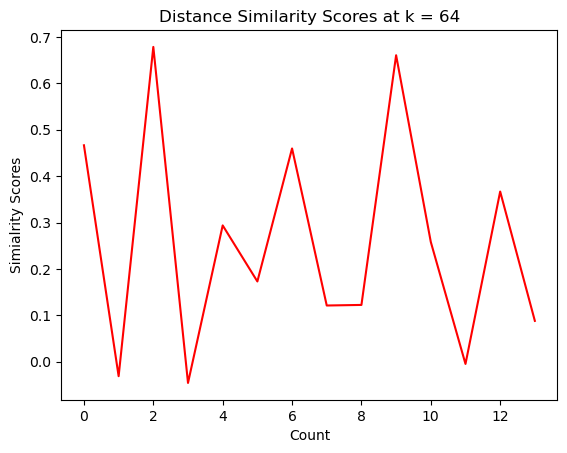

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.466566,1,movie,screen,lightning,0.090159,0.265497,0.016027,-0.296727,0.466566,sky,storm,bolt,camera,thunder
1,[['heat']],-0.031277,0,furnace,coal,stomach,-0.049744,-0.131093,-0.031277,-0.086780,-0.092947,food,acid,heat,ulcers,digestive
2,[['moat']],0.678644,1,bracelet,wrist,moat,-0.135276,0.097474,-0.141267,0.678644,-0.080380,water,castle,arm,moat,fort
3,[['gardener']],-0.045819,1,law,school,lawyer,-0.066016,-0.069516,-0.072105,-0.045819,-0.249000,vineyard,grape,grapes,gardener,wine
4,[['boil']],0.293794,0,multiplication,product,brewing,0.079088,-0.061532,0.293794,0.084853,-0.019387,tea,beer,boil,coffee,drink
5,[['species']],0.172956,0,revising,manuscript,evolving,-0.349915,0.172956,-0.166996,0.018922,-0.011769,life,species,growing,organism,change
6,[['science']],0.459706,0,baker,cake,scientist,0.196722,0.459706,0.329056,0.431526,0.427054,experiment,science,theory,formula,lab
7,[['task']],0.121096,3,sugar,coffee,incentive,-0.240967,0.024717,-0.032409,-0.214869,0.121096,tea,goal,money,work,task
8,[['poor']],0.122349,0,blindness,sight,poverty,0.042312,-0.004933,-0.048743,0.122349,-0.028181,wealth,money,rich,poor,brightness
9,[['container']],0.660675,0,pen,pig,reservoir,0.585767,0.001995,0.568704,0.660675,0.622000,water,dog,lake,container,fish


In [46]:
# For fictional genere and all k values runs

'''Importing all txt File and converting into '''

import pickle

k_arr = ["2", "4", "8", "16", "32", "64"]
genre_arr = ["fiction", "nonfiction", "poetry"]      # Make changes in the loop - currently set to genre_arr[0] as default

fin_cosi, fin_eucd, fin_yule = [], [], []

for i in range(len(genre_arr)):
    avg_plot_cosi, avg_plot_eucd, avg_plot_yule = [], [], []
    for j in range(len(k_arr)):
        
        # Calling LSA model
        path = genre_arr[i] + "_term_embeddings_TXT/term2topic_" + genre_arr[i] + "_" + k_arr[j] + ".txt"
        
        word_file = open(path, "rb")
        word_vectors = pickle.load(word_file)
        word_file.close()
        dict_word_vectors = word_vectors
        
        # Calculating Distance 
        cosi_similarity, avg_cosi = cal_distances(que_list, opt_list, k = k_arr[j], model="LSA")
        
        # Displaying Similarity Scores
        display(cosi_similarity.style.set_caption("Cosine Similarity Scores for " + genre_arr[i] + " at " + "k = " + k_arr[j]))
        
        avg_plot_cosi.append(avg_cosi)
        
    fin_cosi.append(avg_plot_cosi)


# Ravlling to convert into 1D array to respace for plotting
cosi = np.ravel(fin_cosi)       

cosi_2D = np.reshape(cosi, (-1, len(fin_cosi[0]))) 

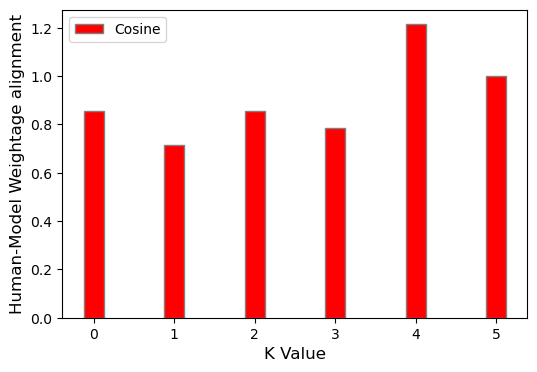

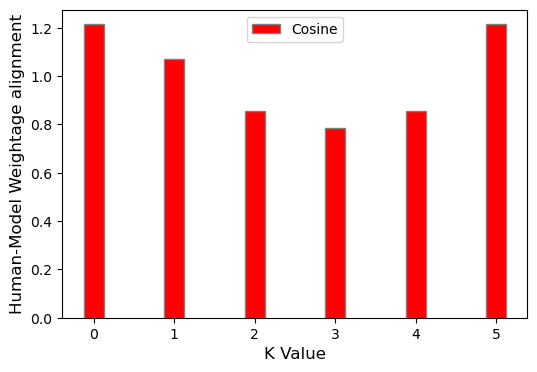

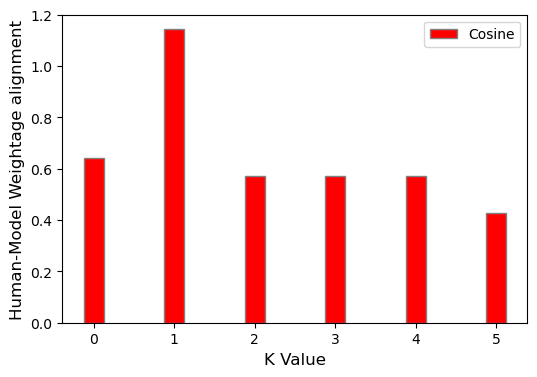

In [47]:
performance_graph(cosi_2D, k_arr)

#### Glove 

In [34]:
## Parsing File for non-LSA models

def parse_file(file_name):
    word_vectors = {}
    with open(file_name, encoding='utf-8') as f:
        for line in f:
            first_whitespace = line.index(" ")
            word = line[:first_whitespace].strip('"')
            vector = np.array(line[first_whitespace + 1:].split(" "), dtype=np.float32)
            word_vectors[word] = vector
            
    return word_vectors

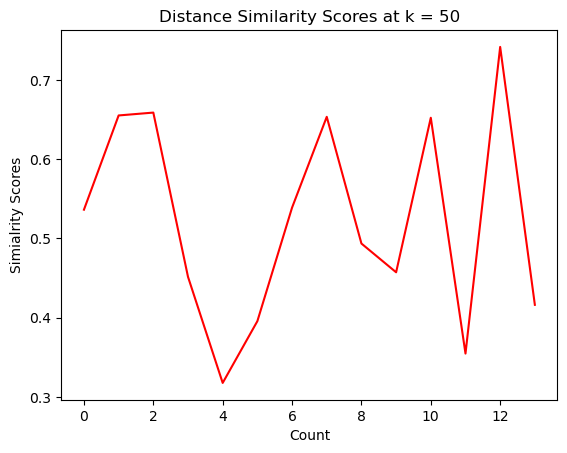

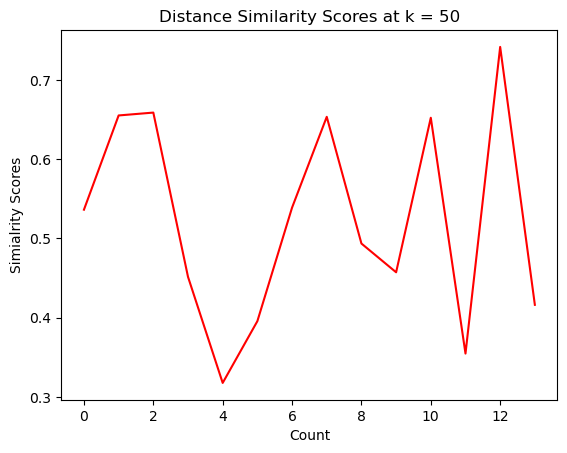

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.536150,0,movie,screen,lightning,0.395288,0.493774,0.504115,0.096913,0.536150,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.655082,0,furnace,coal,stomach,0.588100,0.406118,0.426492,0.655082,0.551608,food,acid,heat,ulcers,digestive
2,[['moat']],0.658699,1,bracelet,wrist,moat,0.404790,0.527339,0.295750,0.658699,0.367859,water,castle,arm,moat,fort
3,[['gardener']],0.451423,0,law,school,lawyer,0.330841,0.207405,0.137003,0.451423,0.236548,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.317559,0,multiplication,product,brewing,0.290889,0.317559,0.152538,0.306338,0.236103,tea,beer,boil,coffee,drink
5,[['organism']],0.395514,2,revising,manuscript,evolving,0.367451,0.269204,0.311211,0.395514,0.201272,life,species,growing,organism,change
6,[['lab']],0.538776,1,baker,cake,scientist,0.471778,0.535704,0.427289,0.205340,0.538776,experiment,science,theory,formula,lab
7,[['money']],0.653351,0,sugar,coffee,incentive,0.001482,0.467356,0.653351,0.550635,0.564094,tea,goal,money,work,task
8,[['poor']],0.493459,2,blindness,sight,poverty,0.363379,0.376580,0.330325,0.493459,-0.216525,wealth,money,rich,poor,brightness
9,[['lake']],0.457175,1,pen,pig,reservoir,0.416991,-0.150106,0.457175,0.291252,0.295031,water,dog,lake,container,fish


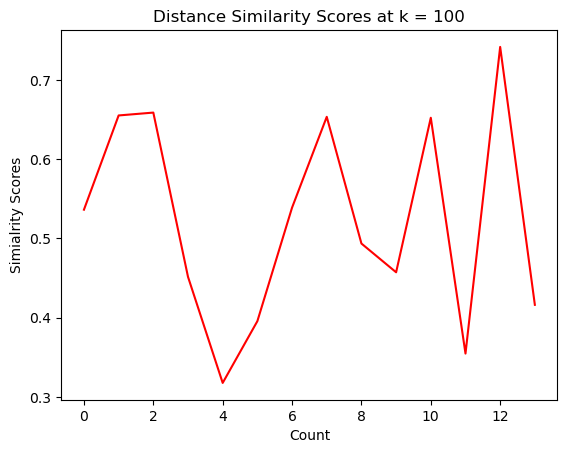

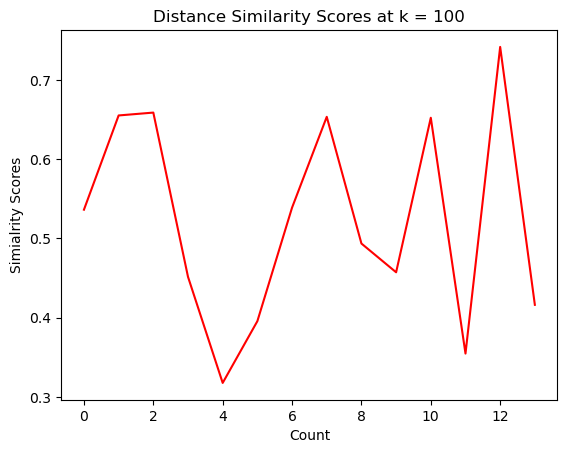

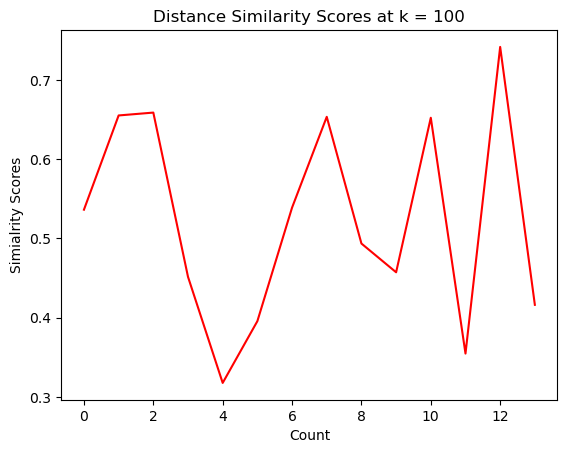

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.536150,0,movie,screen,lightning,0.395288,0.493774,0.504115,0.096913,0.536150,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.655082,0,furnace,coal,stomach,0.588100,0.406118,0.426492,0.655082,0.551608,food,acid,heat,ulcers,digestive
2,[['moat']],0.658699,1,bracelet,wrist,moat,0.404790,0.527339,0.295750,0.658699,0.367859,water,castle,arm,moat,fort
3,[['gardener']],0.451423,0,law,school,lawyer,0.330841,0.207405,0.137003,0.451423,0.236548,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.317559,0,multiplication,product,brewing,0.290889,0.317559,0.152538,0.306338,0.236103,tea,beer,boil,coffee,drink
5,[['organism']],0.395514,2,revising,manuscript,evolving,0.367451,0.269204,0.311211,0.395514,0.201272,life,species,growing,organism,change
6,[['lab']],0.538776,1,baker,cake,scientist,0.471778,0.535704,0.427289,0.205340,0.538776,experiment,science,theory,formula,lab
7,[['money']],0.653351,0,sugar,coffee,incentive,0.001482,0.467356,0.653351,0.550635,0.564094,tea,goal,money,work,task
8,[['poor']],0.493459,2,blindness,sight,poverty,0.363379,0.376580,0.330325,0.493459,-0.216525,wealth,money,rich,poor,brightness
9,[['lake']],0.457175,1,pen,pig,reservoir,0.416991,-0.150106,0.457175,0.291252,0.295031,water,dog,lake,container,fish


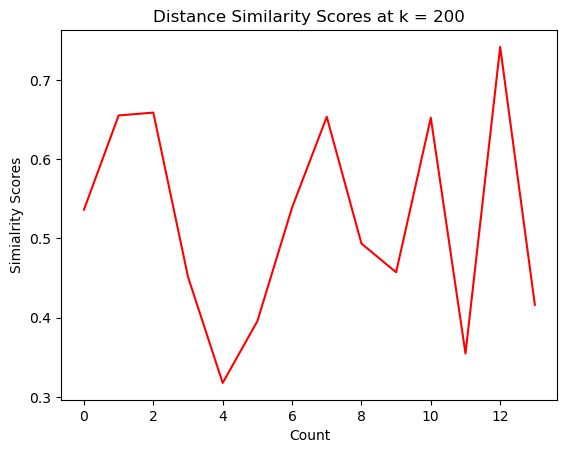

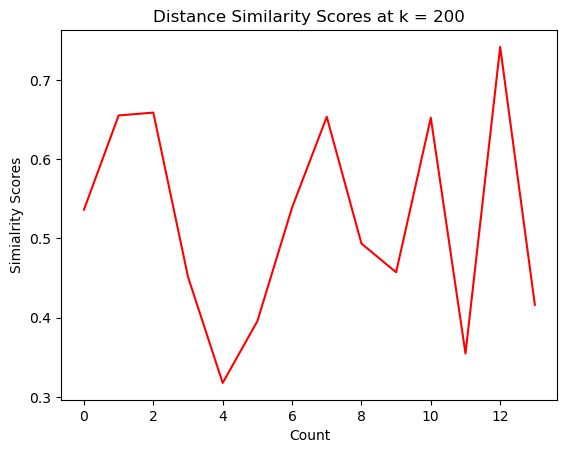

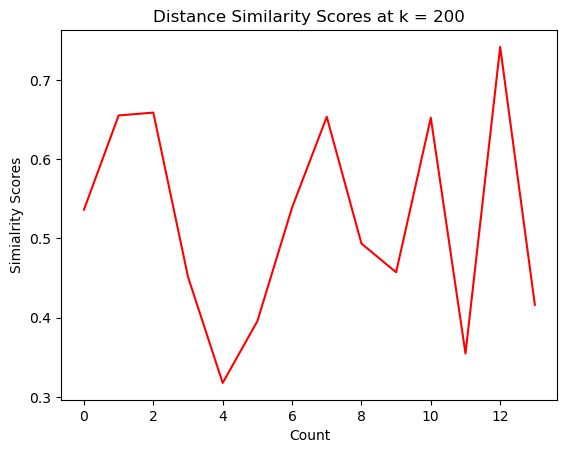

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.536150,0,movie,screen,lightning,0.395288,0.493774,0.504115,0.096913,0.536150,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.655082,0,furnace,coal,stomach,0.588100,0.406118,0.426492,0.655082,0.551608,food,acid,heat,ulcers,digestive
2,[['moat']],0.658699,1,bracelet,wrist,moat,0.404790,0.527339,0.295750,0.658699,0.367859,water,castle,arm,moat,fort
3,[['gardener']],0.451423,0,law,school,lawyer,0.330841,0.207405,0.137003,0.451423,0.236548,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.317559,0,multiplication,product,brewing,0.290889,0.317559,0.152538,0.306338,0.236103,tea,beer,boil,coffee,drink
5,[['organism']],0.395514,2,revising,manuscript,evolving,0.367451,0.269204,0.311211,0.395514,0.201272,life,species,growing,organism,change
6,[['lab']],0.538776,1,baker,cake,scientist,0.471778,0.535704,0.427289,0.205340,0.538776,experiment,science,theory,formula,lab
7,[['money']],0.653351,0,sugar,coffee,incentive,0.001482,0.467356,0.653351,0.550635,0.564094,tea,goal,money,work,task
8,[['poor']],0.493459,2,blindness,sight,poverty,0.363379,0.376580,0.330325,0.493459,-0.216525,wealth,money,rich,poor,brightness
9,[['lake']],0.457175,1,pen,pig,reservoir,0.416991,-0.150106,0.457175,0.291252,0.295031,water,dog,lake,container,fish


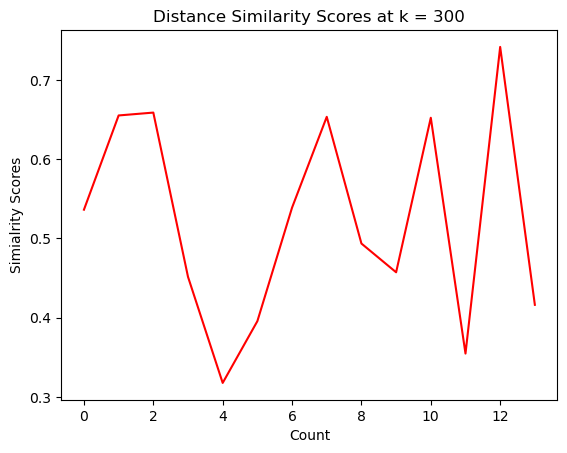

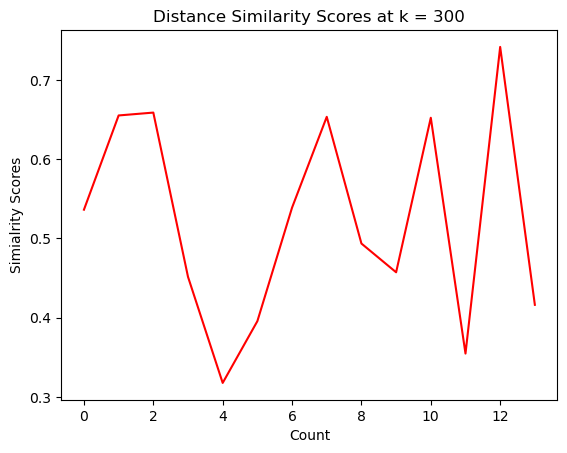

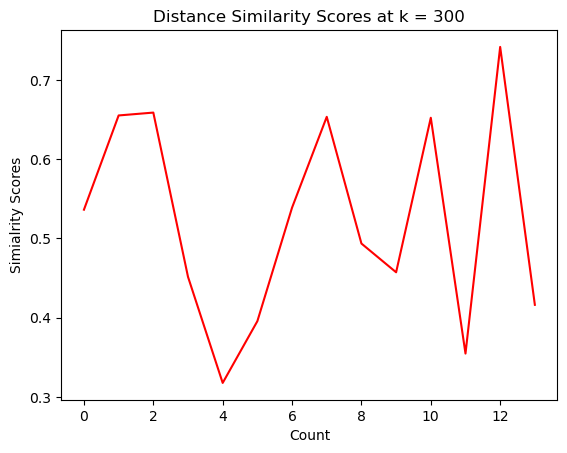

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.536150,0,movie,screen,lightning,0.395288,0.493774,0.504115,0.096913,0.536150,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.655082,0,furnace,coal,stomach,0.588100,0.406118,0.426492,0.655082,0.551608,food,acid,heat,ulcers,digestive
2,[['moat']],0.658699,1,bracelet,wrist,moat,0.404790,0.527339,0.295750,0.658699,0.367859,water,castle,arm,moat,fort
3,[['gardener']],0.451423,0,law,school,lawyer,0.330841,0.207405,0.137003,0.451423,0.236548,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.317559,0,multiplication,product,brewing,0.290889,0.317559,0.152538,0.306338,0.236103,tea,beer,boil,coffee,drink
5,[['organism']],0.395514,2,revising,manuscript,evolving,0.367451,0.269204,0.311211,0.395514,0.201272,life,species,growing,organism,change
6,[['lab']],0.538776,1,baker,cake,scientist,0.471778,0.535704,0.427289,0.205340,0.538776,experiment,science,theory,formula,lab
7,[['money']],0.653351,0,sugar,coffee,incentive,0.001482,0.467356,0.653351,0.550635,0.564094,tea,goal,money,work,task
8,[['poor']],0.493459,2,blindness,sight,poverty,0.363379,0.376580,0.330325,0.493459,-0.216525,wealth,money,rich,poor,brightness
9,[['lake']],0.457175,1,pen,pig,reservoir,0.416991,-0.150106,0.457175,0.291252,0.295031,water,dog,lake,container,fish


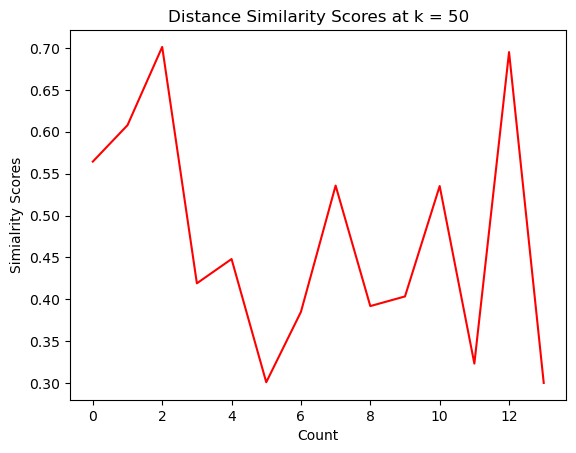

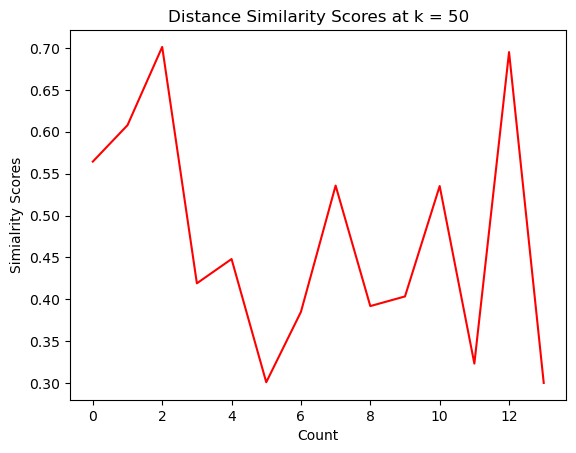

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.564387,0,movie,screen,lightning,0.387251,0.484055,0.531106,0.308239,0.564387,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.607857,0,furnace,coal,stomach,0.489730,0.398323,0.288479,0.607857,0.530216,food,acid,heat,ulcers,digestive
2,[['moat']],0.701312,1,bracelet,wrist,moat,0.358145,0.513583,0.153871,0.701312,0.357932,water,castle,arm,moat,fort
3,[['gardener']],0.419061,0,law,school,lawyer,0.345342,0.236763,0.188068,0.419061,0.229625,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.448055,0,multiplication,product,brewing,0.298019,0.448055,0.079436,0.301683,0.240464,tea,beer,boil,coffee,drink
5,[['organism']],0.300930,1,revising,manuscript,evolving,0.230189,0.239507,0.290529,0.300930,0.162144,life,species,growing,organism,change
6,[['lab']],0.384949,1,baker,cake,scientist,0.280838,0.380229,0.243300,0.010696,0.384949,experiment,science,theory,formula,lab
7,[['money']],0.535739,0,sugar,coffee,incentive,0.051000,0.388767,0.535739,0.476469,0.459187,tea,goal,money,work,task
8,[['poor']],0.391881,2,blindness,sight,poverty,0.342255,0.377684,0.331447,0.391881,-0.222209,wealth,money,rich,poor,brightness
9,[['water']],0.403400,2,pen,pig,reservoir,0.403400,-0.117495,0.378112,0.202747,0.233434,water,dog,lake,container,fish


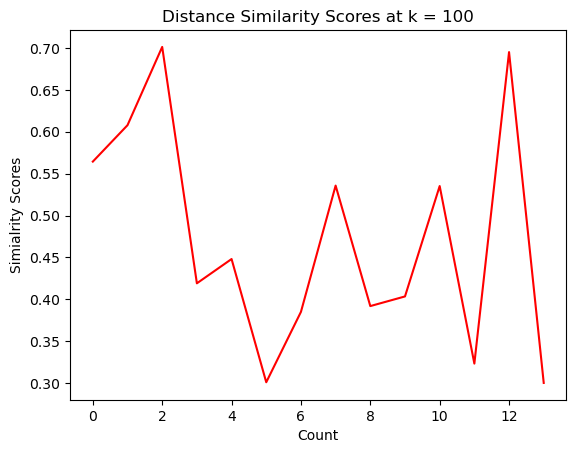

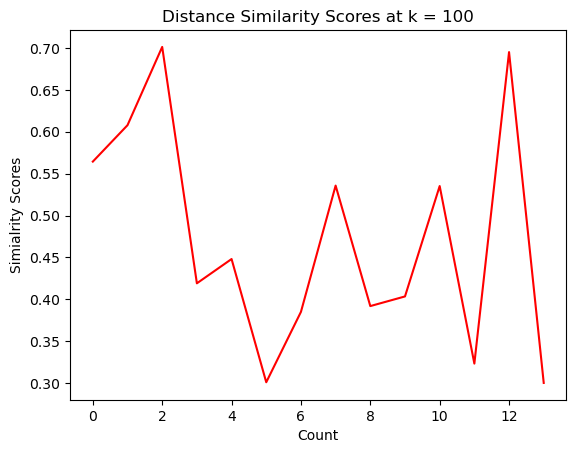

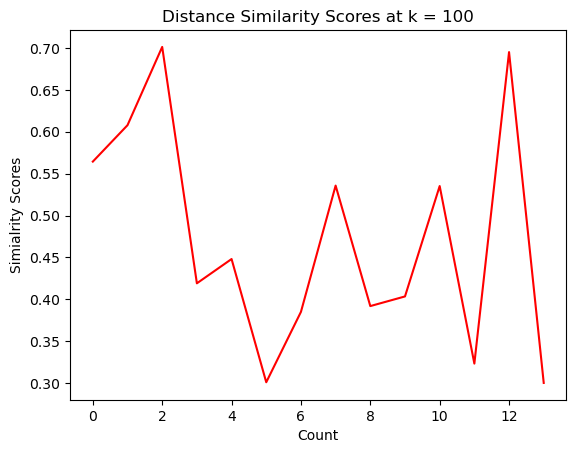

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.564387,0,movie,screen,lightning,0.387251,0.484055,0.531106,0.308239,0.564387,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.607857,0,furnace,coal,stomach,0.489730,0.398323,0.288479,0.607857,0.530216,food,acid,heat,ulcers,digestive
2,[['moat']],0.701312,1,bracelet,wrist,moat,0.358145,0.513583,0.153871,0.701312,0.357932,water,castle,arm,moat,fort
3,[['gardener']],0.419061,0,law,school,lawyer,0.345342,0.236763,0.188068,0.419061,0.229625,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.448055,0,multiplication,product,brewing,0.298019,0.448055,0.079436,0.301683,0.240464,tea,beer,boil,coffee,drink
5,[['organism']],0.300930,1,revising,manuscript,evolving,0.230189,0.239507,0.290529,0.300930,0.162144,life,species,growing,organism,change
6,[['lab']],0.384949,1,baker,cake,scientist,0.280838,0.380229,0.243300,0.010696,0.384949,experiment,science,theory,formula,lab
7,[['money']],0.535739,0,sugar,coffee,incentive,0.051000,0.388767,0.535739,0.476469,0.459187,tea,goal,money,work,task
8,[['poor']],0.391881,2,blindness,sight,poverty,0.342255,0.377684,0.331447,0.391881,-0.222209,wealth,money,rich,poor,brightness
9,[['water']],0.403400,2,pen,pig,reservoir,0.403400,-0.117495,0.378112,0.202747,0.233434,water,dog,lake,container,fish


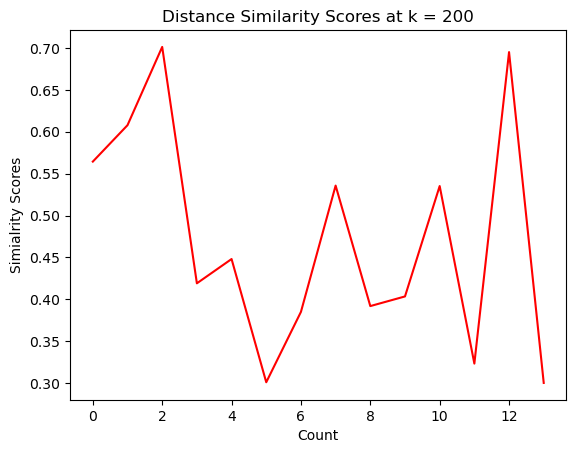

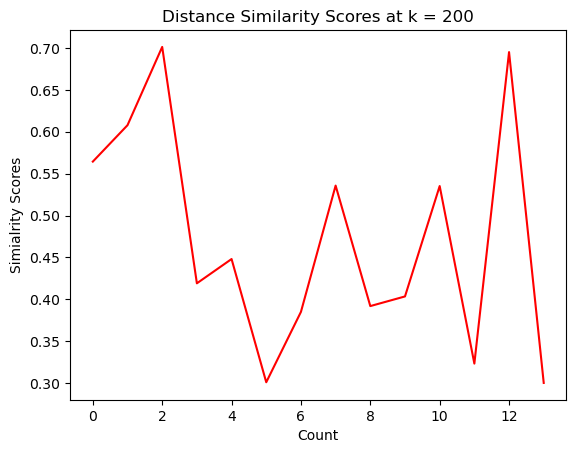

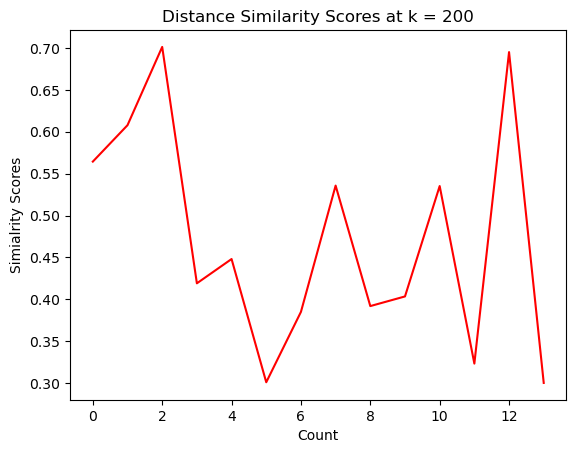

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.564387,0,movie,screen,lightning,0.387251,0.484055,0.531106,0.308239,0.564387,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.607857,0,furnace,coal,stomach,0.489730,0.398323,0.288479,0.607857,0.530216,food,acid,heat,ulcers,digestive
2,[['moat']],0.701312,1,bracelet,wrist,moat,0.358145,0.513583,0.153871,0.701312,0.357932,water,castle,arm,moat,fort
3,[['gardener']],0.419061,0,law,school,lawyer,0.345342,0.236763,0.188068,0.419061,0.229625,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.448055,0,multiplication,product,brewing,0.298019,0.448055,0.079436,0.301683,0.240464,tea,beer,boil,coffee,drink
5,[['organism']],0.300930,1,revising,manuscript,evolving,0.230189,0.239507,0.290529,0.300930,0.162144,life,species,growing,organism,change
6,[['lab']],0.384949,1,baker,cake,scientist,0.280838,0.380229,0.243300,0.010696,0.384949,experiment,science,theory,formula,lab
7,[['money']],0.535739,0,sugar,coffee,incentive,0.051000,0.388767,0.535739,0.476469,0.459187,tea,goal,money,work,task
8,[['poor']],0.391881,2,blindness,sight,poverty,0.342255,0.377684,0.331447,0.391881,-0.222209,wealth,money,rich,poor,brightness
9,[['water']],0.403400,2,pen,pig,reservoir,0.403400,-0.117495,0.378112,0.202747,0.233434,water,dog,lake,container,fish


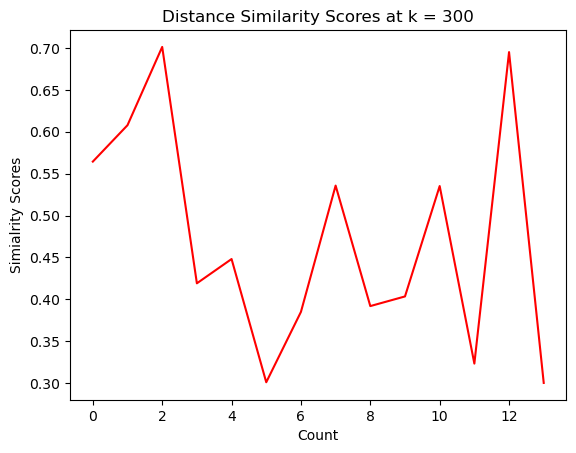

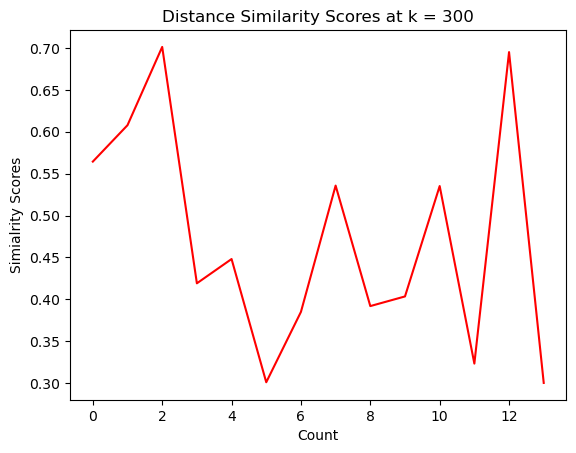

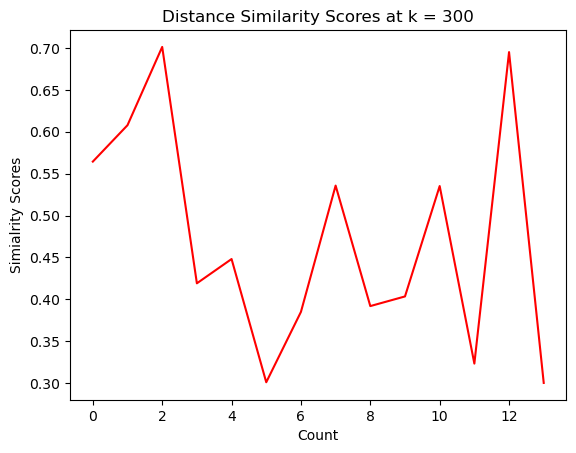

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.564387,0,movie,screen,lightning,0.387251,0.484055,0.531106,0.308239,0.564387,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.607857,0,furnace,coal,stomach,0.489730,0.398323,0.288479,0.607857,0.530216,food,acid,heat,ulcers,digestive
2,[['moat']],0.701312,1,bracelet,wrist,moat,0.358145,0.513583,0.153871,0.701312,0.357932,water,castle,arm,moat,fort
3,[['gardener']],0.419061,0,law,school,lawyer,0.345342,0.236763,0.188068,0.419061,0.229625,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.448055,0,multiplication,product,brewing,0.298019,0.448055,0.079436,0.301683,0.240464,tea,beer,boil,coffee,drink
5,[['organism']],0.300930,1,revising,manuscript,evolving,0.230189,0.239507,0.290529,0.300930,0.162144,life,species,growing,organism,change
6,[['lab']],0.384949,1,baker,cake,scientist,0.280838,0.380229,0.243300,0.010696,0.384949,experiment,science,theory,formula,lab
7,[['money']],0.535739,0,sugar,coffee,incentive,0.051000,0.388767,0.535739,0.476469,0.459187,tea,goal,money,work,task
8,[['poor']],0.391881,2,blindness,sight,poverty,0.342255,0.377684,0.331447,0.391881,-0.222209,wealth,money,rich,poor,brightness
9,[['water']],0.403400,2,pen,pig,reservoir,0.403400,-0.117495,0.378112,0.202747,0.233434,water,dog,lake,container,fish


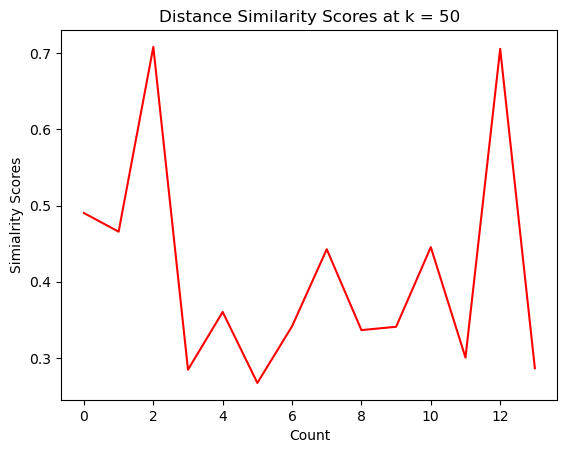

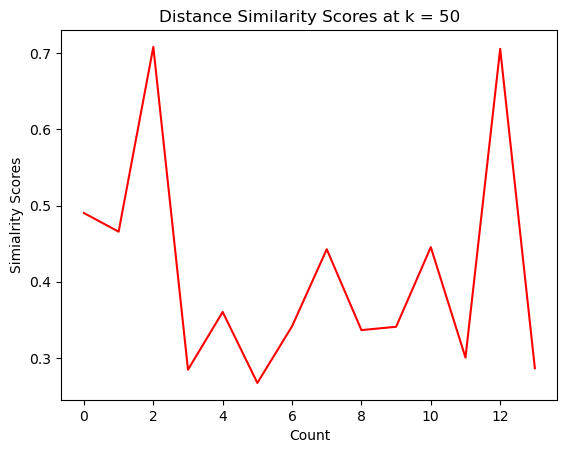

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.490227,2,movie,screen,lightning,0.324036,0.449286,0.431357,0.201496,0.490227,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.465761,0,furnace,coal,stomach,0.432102,0.356448,0.253863,0.465761,0.421297,food,acid,heat,ulcers,digestive
2,[['moat']],0.708485,1,bracelet,wrist,moat,0.349983,0.426487,0.195579,0.708485,0.339579,water,castle,arm,moat,fort
3,[['gardener']],0.284451,0,law,school,lawyer,0.196412,0.122876,0.105172,0.284451,0.110488,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.360264,0,multiplication,product,brewing,0.199886,0.360264,0.068575,0.224852,0.190229,tea,beer,boil,coffee,drink
5,[['organism']],0.267044,1,revising,manuscript,evolving,0.166949,0.200164,0.227618,0.267044,0.136295,life,species,growing,organism,change
6,[['lab']],0.341475,1,baker,cake,scientist,0.223772,0.308984,0.156014,0.017196,0.341475,experiment,science,theory,formula,lab
7,[['money']],0.442675,0,sugar,coffee,incentive,0.048776,0.343082,0.442675,0.412789,0.345227,tea,goal,money,work,task
8,[['poor']],0.336443,1,blindness,sight,poverty,0.262779,0.257475,0.252068,0.336443,-0.124027,wealth,money,rich,poor,brightness
9,[['water']],0.340820,2,pen,pig,reservoir,0.340820,-0.030772,0.297424,0.150478,0.191121,water,dog,lake,container,fish


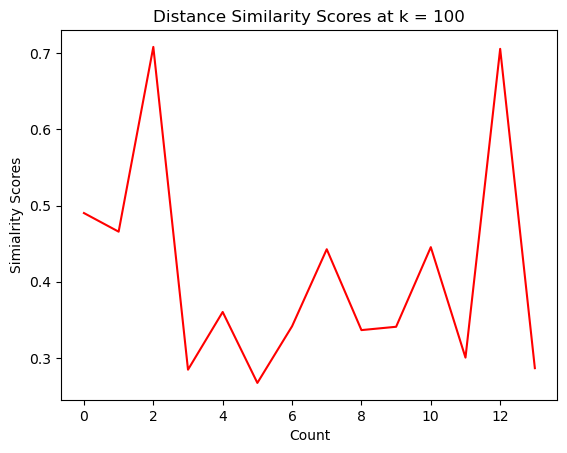

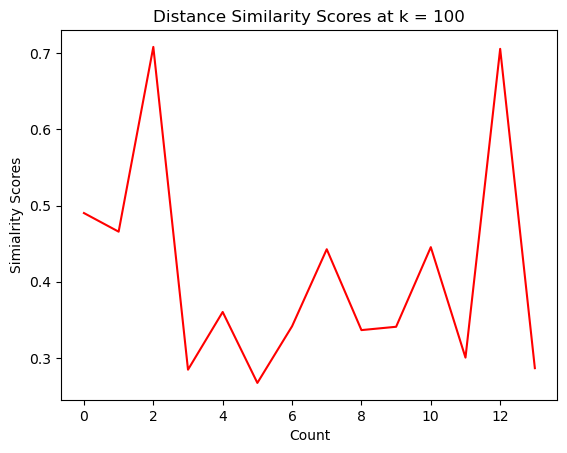

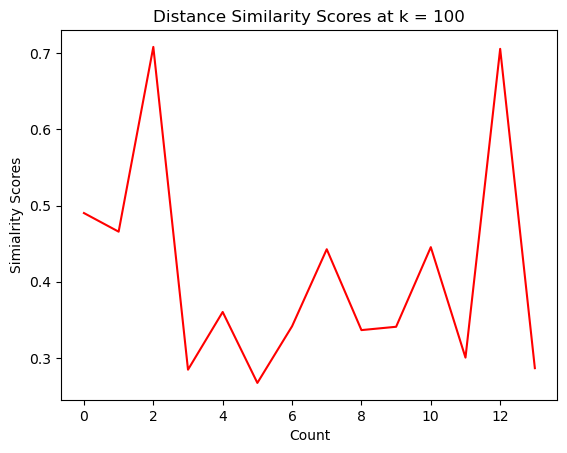

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.490227,2,movie,screen,lightning,0.324036,0.449286,0.431357,0.201496,0.490227,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.465761,0,furnace,coal,stomach,0.432102,0.356448,0.253863,0.465761,0.421297,food,acid,heat,ulcers,digestive
2,[['moat']],0.708485,1,bracelet,wrist,moat,0.349983,0.426487,0.195579,0.708485,0.339579,water,castle,arm,moat,fort
3,[['gardener']],0.284451,0,law,school,lawyer,0.196412,0.122876,0.105172,0.284451,0.110488,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.360264,0,multiplication,product,brewing,0.199886,0.360264,0.068575,0.224852,0.190229,tea,beer,boil,coffee,drink
5,[['organism']],0.267044,1,revising,manuscript,evolving,0.166949,0.200164,0.227618,0.267044,0.136295,life,species,growing,organism,change
6,[['lab']],0.341475,1,baker,cake,scientist,0.223772,0.308984,0.156014,0.017196,0.341475,experiment,science,theory,formula,lab
7,[['money']],0.442675,0,sugar,coffee,incentive,0.048776,0.343082,0.442675,0.412789,0.345227,tea,goal,money,work,task
8,[['poor']],0.336443,1,blindness,sight,poverty,0.262779,0.257475,0.252068,0.336443,-0.124027,wealth,money,rich,poor,brightness
9,[['water']],0.340820,2,pen,pig,reservoir,0.340820,-0.030772,0.297424,0.150478,0.191121,water,dog,lake,container,fish


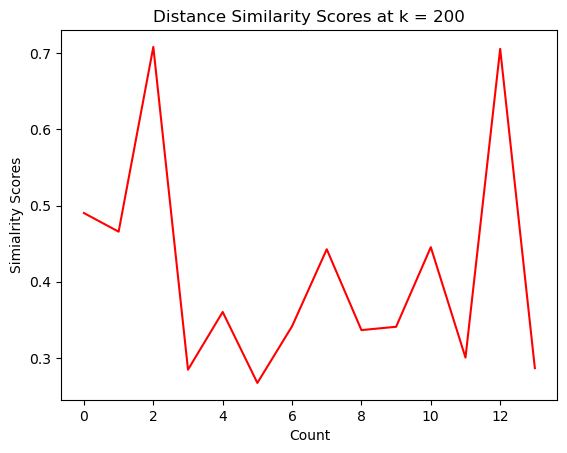

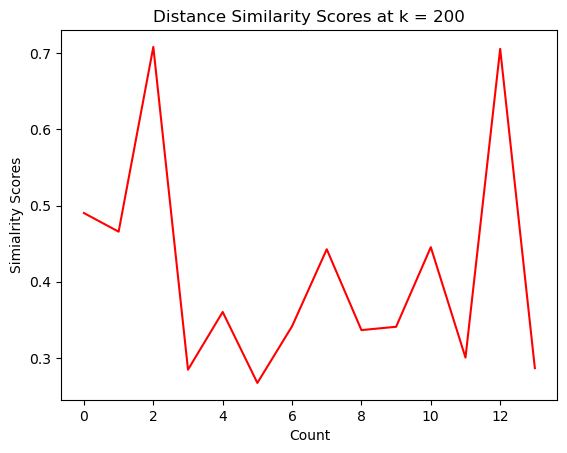

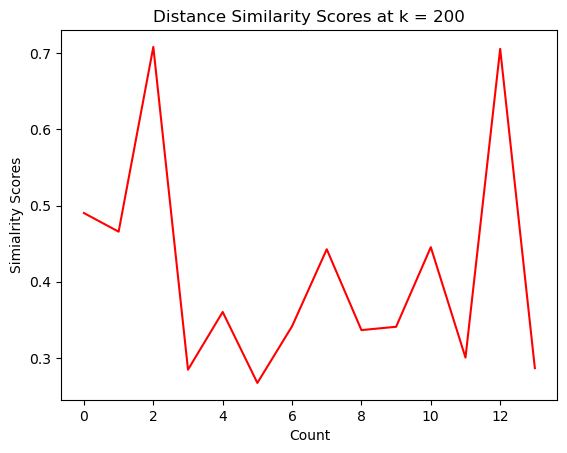

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.490227,2,movie,screen,lightning,0.324036,0.449286,0.431357,0.201496,0.490227,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.465761,0,furnace,coal,stomach,0.432102,0.356448,0.253863,0.465761,0.421297,food,acid,heat,ulcers,digestive
2,[['moat']],0.708485,1,bracelet,wrist,moat,0.349983,0.426487,0.195579,0.708485,0.339579,water,castle,arm,moat,fort
3,[['gardener']],0.284451,0,law,school,lawyer,0.196412,0.122876,0.105172,0.284451,0.110488,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.360264,0,multiplication,product,brewing,0.199886,0.360264,0.068575,0.224852,0.190229,tea,beer,boil,coffee,drink
5,[['organism']],0.267044,1,revising,manuscript,evolving,0.166949,0.200164,0.227618,0.267044,0.136295,life,species,growing,organism,change
6,[['lab']],0.341475,1,baker,cake,scientist,0.223772,0.308984,0.156014,0.017196,0.341475,experiment,science,theory,formula,lab
7,[['money']],0.442675,0,sugar,coffee,incentive,0.048776,0.343082,0.442675,0.412789,0.345227,tea,goal,money,work,task
8,[['poor']],0.336443,1,blindness,sight,poverty,0.262779,0.257475,0.252068,0.336443,-0.124027,wealth,money,rich,poor,brightness
9,[['water']],0.340820,2,pen,pig,reservoir,0.340820,-0.030772,0.297424,0.150478,0.191121,water,dog,lake,container,fish


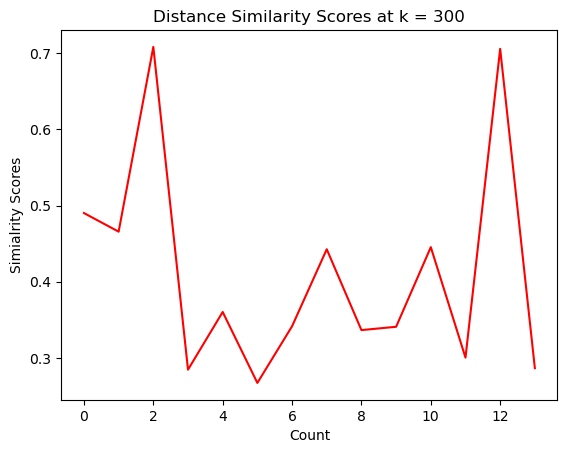

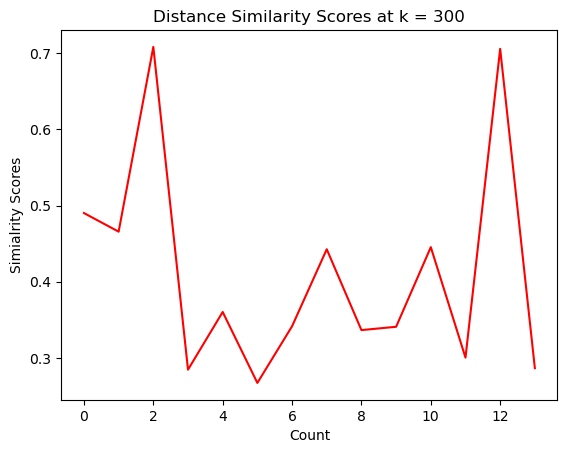

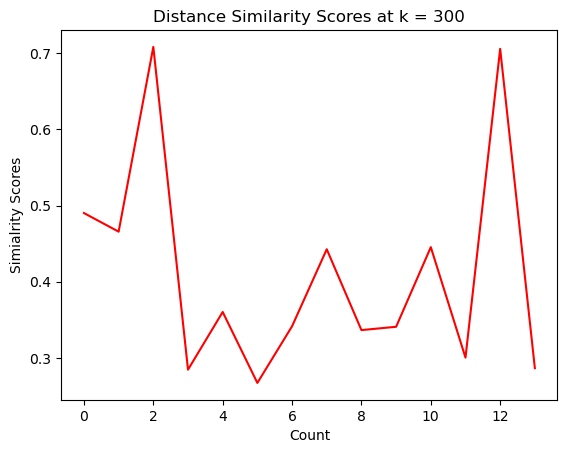

,Calculated,Model Similarity,Score,Quest 1,Quest 2,Quest 3,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Prompt 1,Prompt 2,Prompt 3,Prompt 4,Prompt 5
0,[['thunder']],0.490227,2,movie,screen,lightning,0.324036,0.449286,0.431357,0.201496,0.490227,sky,storm,bolt,camera,thunder
1,[['ulcers']],0.465761,0,furnace,coal,stomach,0.432102,0.356448,0.253863,0.465761,0.421297,food,acid,heat,ulcers,digestive
2,[['moat']],0.708485,1,bracelet,wrist,moat,0.349983,0.426487,0.195579,0.708485,0.339579,water,castle,arm,moat,fort
3,[['gardener']],0.284451,0,law,school,lawyer,0.196412,0.122876,0.105172,0.284451,0.110488,vineyard,grape,grapes,gardener,wine
4,[['beer']],0.360264,0,multiplication,product,brewing,0.199886,0.360264,0.068575,0.224852,0.190229,tea,beer,boil,coffee,drink
5,[['organism']],0.267044,1,revising,manuscript,evolving,0.166949,0.200164,0.227618,0.267044,0.136295,life,species,growing,organism,change
6,[['lab']],0.341475,1,baker,cake,scientist,0.223772,0.308984,0.156014,0.017196,0.341475,experiment,science,theory,formula,lab
7,[['money']],0.442675,0,sugar,coffee,incentive,0.048776,0.343082,0.442675,0.412789,0.345227,tea,goal,money,work,task
8,[['poor']],0.336443,1,blindness,sight,poverty,0.262779,0.257475,0.252068,0.336443,-0.124027,wealth,money,rich,poor,brightness
9,[['water']],0.340820,2,pen,pig,reservoir,0.340820,-0.030772,0.297424,0.150478,0.191121,water,dog,lake,container,fish


In [35]:
glove_arr = ["50", "100", "200", "300"]

## Calling Glove Model

fin_cosi, fin_eucd, fin_yule = [], [], []

for i in range(len(genre_arr)):
    avg_plot_cosi, avg_plot_eucd, avg_plot_yule = [], [], []
    for j in range(len(glove_arr)):
        
        path = "glove.6B/glove.6B." + glove_arr[i] + "d.txt"
        glove_word_vector = parse_file(path)
        
        cosi_similarity_glove, avg_cosi = cal_distances(que_list, opt_list, k = glove_arr[j], model="GloVe")

        # Displaying Similarity Scores
        display(cosi_similarity_glove.style.set_caption("Glove Cosine Similarity Scores for " + genre_arr[i] + " using Glove at " + glove_arr[j]))

        avg_plot_cosi.append(avg_cosi)
    
    fin_cosi.append(avg_plot_cosi)
    
cosi = np.ravel(fin_cosi)
        
cosi_2D = np.reshape(cosi, (-1, len(fin_cosi[0])))

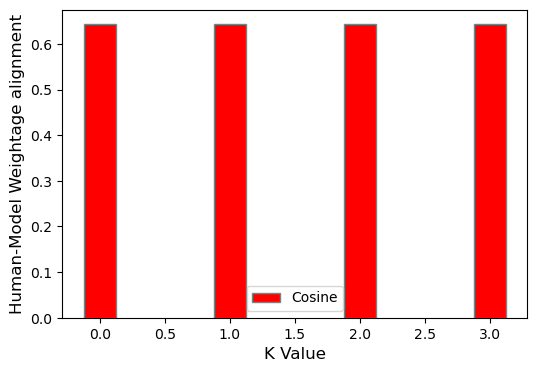

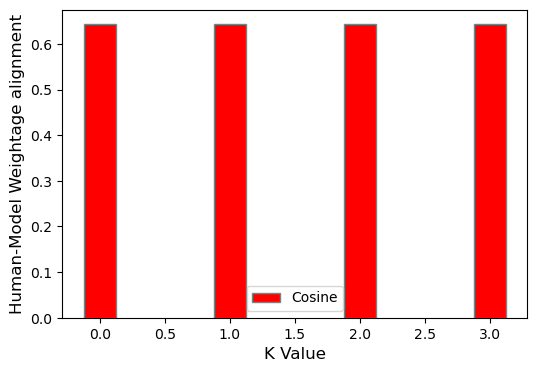

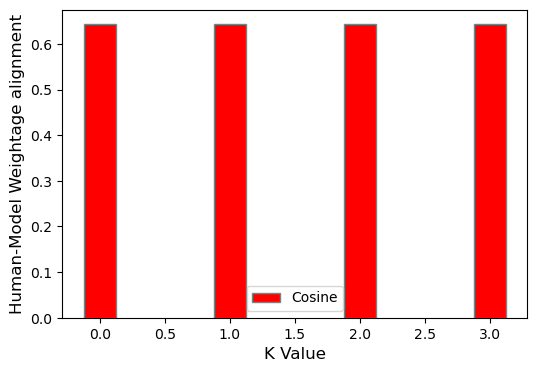

In [36]:
performance_graph(cosi_2D, glove_arr)